In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# (a.i)American Put Value

In [2]:
# The function of American Put value

def AmericanPut(S0, T, N, r, sigma, K):
    
    # Some value would be used
    dt = T/N
    u = np.exp(sigma * np.sqrt(dt))   

    q = (1 - np.exp(-sigma * np.sqrt(dt))) / (np.exp(sigma * np.sqrt(dt)) - np.exp(-sigma * np.sqrt(dt)))

    
    # Create empty set to store the value later
    asset_tree = np.zeros((N+1, N+1))
    intrinsic_tree = np.zeros((N+1, N+1))
    hold_tree = np.zeros((N+1, N+1))
    option_tree = np.zeros((N+1, N+1))

 
    # Calculate the asset price, put value at maturity
    # Calculate the asset price on every node
    asset_tree[0,0] = S0
    for i in range(N, 0, -1):
        for j in range(0, i+1, 1):
            asset_tree[j,i] = S0 * (u ** (i-j*2)) * np.exp(i * r * dt)
    
    
    # Calculate the intrinsic tree
    for i in range(N, -1, -1):
        for j in range(0, i+1, 1):
            intrinsic_tree[j,i] = np.maximum(K - asset_tree[j,i], 0) 
    
    # Calculate the put value at maturity for hold_tree and option_tree
    hold_tree[:,N] = np.maximum(K - asset_tree[:,N], 0)
    option_tree[:,N] = np.maximum(K - asset_tree[:,N], 0)
    
    
    # Calculate the put value for hold_tree and option_tree by backward, in unit of time step
    for i in range(N, 0, -1):    
        for j in range(0, i, 1): 
            hold_tree[j,i-1] = np.exp(-r * dt) * (q * option_tree[j,i] + (1-q) * option_tree[j+1,i])
            option_tree[j,i-1] = np.maximum(hold_tree[j,i-1], intrinsic_tree[j,i-1])
            
    return asset_tree, option_tree, hold_tree, intrinsic_tree

In [3]:
asset_tree, option_tree, hold_tree, intrinsic_tree = AmericanPut(10, 1, 5000, 0.02, 0.2, 10)

# (a.i)Exercise Boundary

In [4]:
# The Exercise Boundary
def ExerciseBoundary(asset_tree, option_tree, N, K):
    
    # use K - asset price > option value  as a indicator, 
    # and use it on the asset_tree to find the scenario that we exercise early     (at each time step)
    #     we make the value of asset price scenario that not exercise early equal to 0
    # then we find the sup of the asset price that make we exercise early， at each time step
    
    exercise_boundary_set = asset_tree.copy()
    exercise_boundary_set[(K - asset_tree - option_tree) < 0] = 0 
    exercise_boundary = exercise_boundary_set.max(axis = 0)
    
    plt.plot(np.arange(0, N+1),exercise_boundary)
    plt.hlines(y = 10,xmin = 0, xmax = N+100, color = 'red', linestyles = 'dashed')
    plt.ylim([7.35,10.1])
    plt.xlabel('Time Step (T=1, N=5000)')
    plt.ylabel('Asset Price')
    plt.title('Exercise Boundary for the American Put Option with K=10')
    
    return exercise_boundary

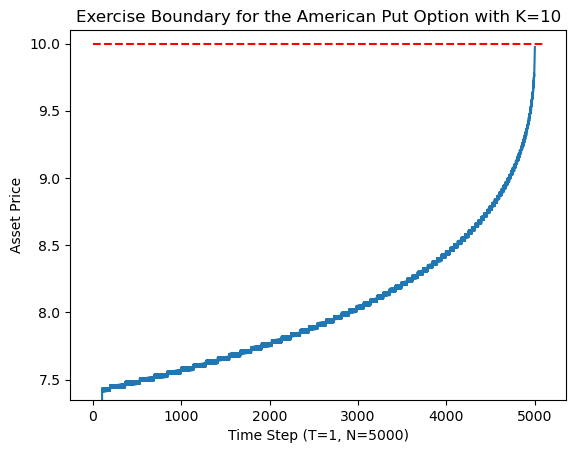

In [5]:
exercise_boundary = ExerciseBoundary(asset_tree, option_tree, 5000, 10)

# (a.ii) Plot the hedging strategy as a function of the spot price S

In [6]:
def HedgingAme(option_tree, asset_tree, T, N, r):
    dt = T/N
    sigma_0 = np.zeros((N+1, N+1))
    sigma_1 = np.zeros((N+1, N+1))
    
    # hedge(replicate) the option value, not the payoff
    # Use the option_tree, which represents the option value, for American Option
    # Use the bank account (to invest directly) and long/short stock to hedge(replicate)
    for i in range(N, 0, -1): 
        for j in range(0, i, 1):  
            sigma_1[j,i-1] = (option_tree[j,i] - option_tree[j+1,i]) / (asset_tree[j,i] - asset_tree[j+1,i])
            sigma_0[j,i-1] = (option_tree[j+1,i] - sigma_1[j,i-1] * asset_tree[j+1,i]) / np.exp(r * dt) 
    
    return pd.DataFrame(sigma_0), pd.DataFrame(sigma_1)

In [7]:
sigma_0_ame, sigma_1_ame = HedgingAme(option_tree, asset_tree, 1, 5000, 0.02)

## t = 1

On Pizza: "At expiry the hedge is either to hold the stock or not... as that is what you would pay"

At t = 1 (the maturity of put option),

When the asset price >= K (=10), we hold the stock and not exercise the put option.

When the asset price < K (=10), we exercise the put option and short the stock.

In [8]:
# Since we have 5000 steps, at t = 1, the asset price that nearly equal to 10 should be in row # 2503
# and at row # 2504, the asset price will smaller than 10

In [9]:
asset_tree_df = pd.DataFrame(asset_tree)

In [10]:
asset_tree_df[5000][2503]

10.030340306338369

In [11]:
asset_tree_df[5000][2504]

9.973760316410726

## For other time point t = 0, 1/4, 1/2, 3/4

In [12]:
def HedgingPlot(sigma_0,sigma_1, N):
    
    # t = 0
    print([sigma_0[0][0], sigma_1[0][0]])
    
    plt.figure(figsize = (21,10))
    # t = 1/4
    plt.plot(range(0,N//4 + 1),sigma_0[N//4][0 : N//4 + 1], label = 'bank account 1/4', color = 'blue')
    plt.plot(range(0,N//4 + 1),sigma_1[N//4][0 : N//4 + 1], label = 'stock 1/4', color = 'blue')
    # t = 1/2
    plt.plot(range(0,N//2 + 1),sigma_0[N//2][0 : N//2 + 1], label = 'bank account 1/2', color = 'green')
    plt.plot(range(0,N//2 + 1),sigma_1[N//2][0 : N//2 + 1], label = 'stock 1/2', color = 'green')
    # t = 3/4
    plt.plot(range(0,3*N//4 + 1),sigma_0[3*N//4][0 : 3*N//4 + 1], label = 'bank account 3/4', color = 'red')
    plt.plot(range(0,3*N//4 + 1),sigma_1[3*N//4][0 : 3*N//4 + 1], label = 'stock 3/4', color = 'red')

    plt.xlabel('Node')
    plt.ylabel('Unit')
    plt.title('Hedge at time point t = 1/4, 1/2, 3/4')
    plt.legend()
    plt.show()
    
    return

[5.067940012198002, -0.4356819574412066]


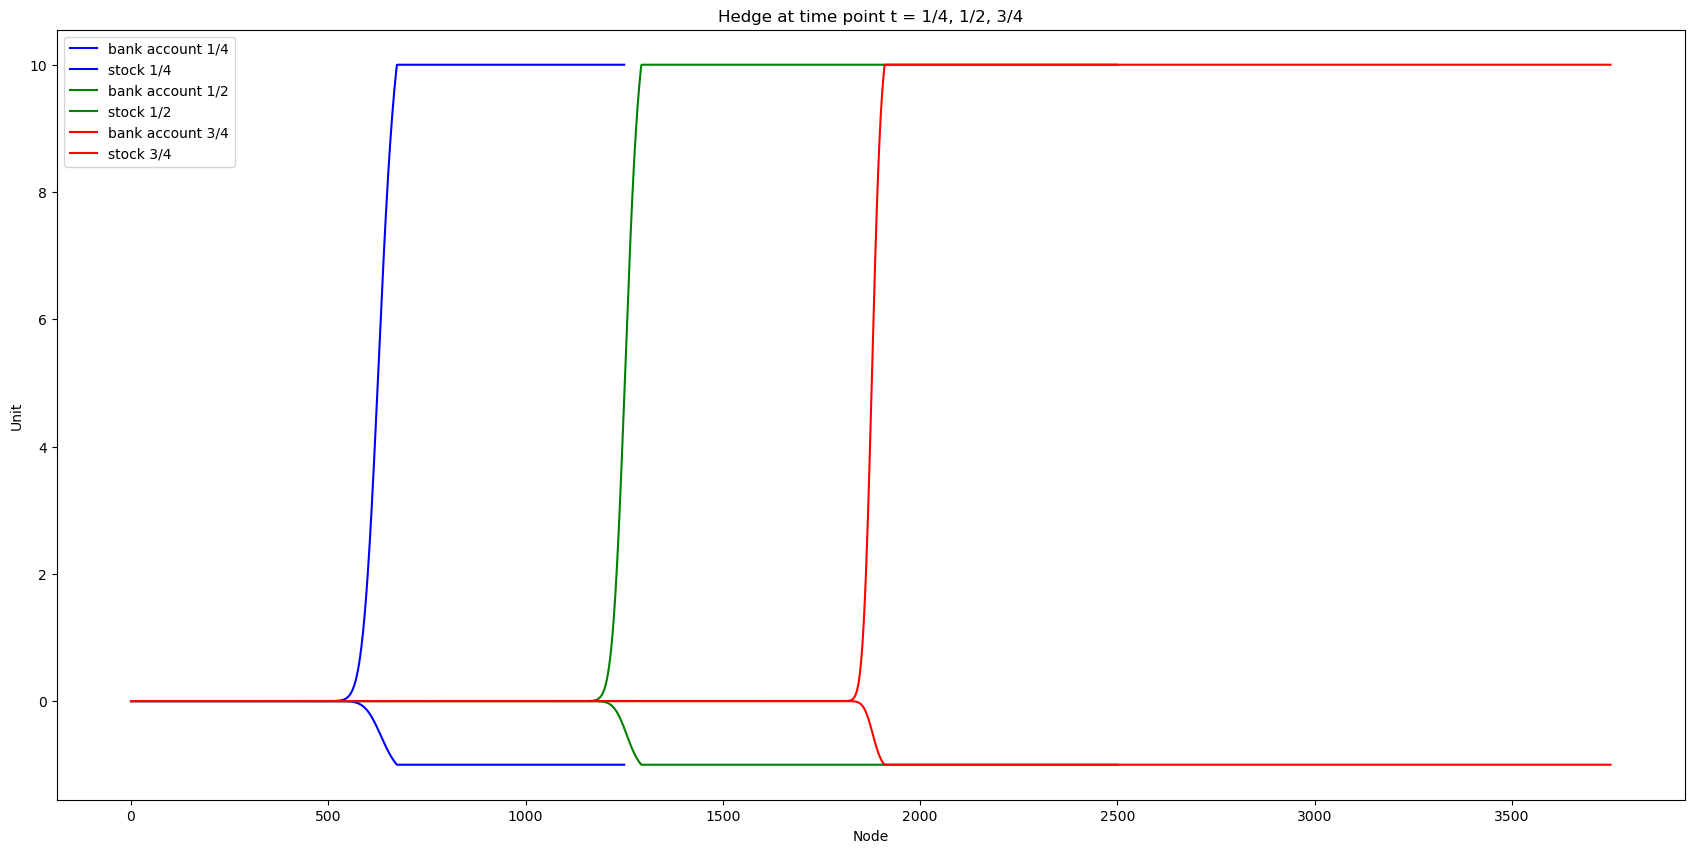

In [13]:
HedgingPlot(sigma_0_ame, sigma_1_ame, 5000)

## Compare to European

### t = 1

For both American and European put option, at t=1 (the maturity of put option),,

When the asset price >= K (=10), we hold the stock and not exercise the put option.

When the asset price < K (=10), we exercise the put option and short the stock.

Same as American

### For other time point t = 0, 1/4, 1/2, 3/4

In [14]:
def Euro_tree(asset_tree, T, N, r, sigma, K):
    dt = T/N
    q = (1 - np.exp(-sigma * np.sqrt(dt))) / (np.exp(sigma * np.sqrt(dt)) - np.exp(-sigma * np.sqrt(dt)))
    euro_tree = np.zeros((N+1, N+1))
    
    euro_tree[:,N] = np.maximum(K - asset_tree[:,N], 0)

    for i in range(N, 0, -1):    
            for j in range(0, i, 1): 
                euro_tree[j,i-1] = np.exp(-r * dt) * (q * euro_tree[j,i] + (1-q) * euro_tree[j+1,i])
    return euro_tree

In [15]:
euro_tree = Euro_tree(asset_tree, 1, 5000, 0.02, 0.2, 10)

In [16]:
def HedgingEur(euro_tree, asset_tree, T, N, r):
    
    dt = T/N
    sigma_0 = np.zeros((N+1, N+1))
    sigma_1 = np.zeros((N+1, N+1))

    # Now use the hold_tree for European Option
    # Use the bank account (to invest directly) and long/short stock to hedge(replicate)
    for i in range(N, 0, -1): 
        for j in range(0, i, 1):  
            sigma_1[j,i-1] = (euro_tree[j,i] - euro_tree[j+1,i]) / (asset_tree[j,i] - asset_tree[j+1,i])
            sigma_0[j,i-1] = (euro_tree[j+1,i] - sigma_1[j,i-1] * asset_tree[j+1,i]) / np.exp(r * dt) 
    
    return pd.DataFrame(sigma_0), pd.DataFrame(sigma_1)

In [17]:
sigma_0_eur, sigma_1_eur = HedgingEur(hold_tree, asset_tree, 1, 5000, 0.02)

[5.067940012198002, -0.4356819574412066]


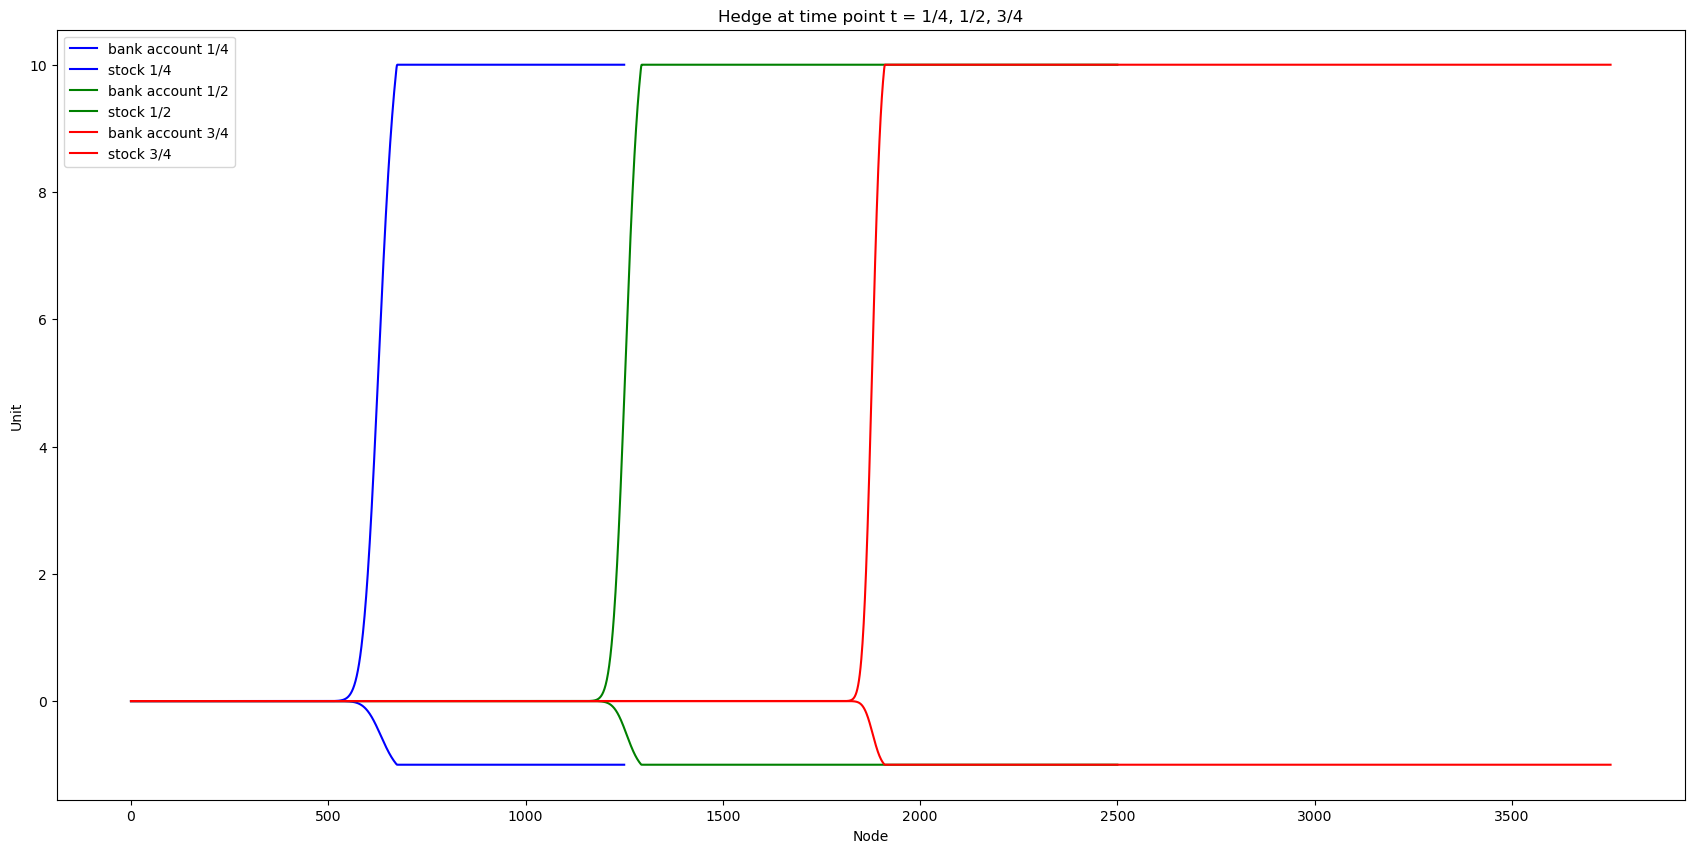

In [18]:
HedgingPlot(sigma_0_eur,sigma_1_eur, 5000)

# (a.iii) How results vary as volatility and risk-free rate vary

Original volatility = 0.2, risk-free rate = 0.02

## Change volatility 0.1, 0.2, 0.3, 0.5, 0.7, 0.9

In [8]:
asset_tree_01, option_tree_01, hold_tree_01, intrinsic_tree_01 = AmericanPut(10, 1, 5000, 0.02, 0.1, 10)
asset_tree_02, option_tree_02, hold_tree_02, intrinsic_tree_02 = AmericanPut(10, 1, 5000, 0.02, 0.2, 10)
asset_tree_03, option_tree_03, hold_tree_03, intrinsic_tree_03 = AmericanPut(10, 1, 5000, 0.02, 0.3, 10)
asset_tree_05, option_tree_05, hold_tree_05, intrinsic_tree_05 = AmericanPut(10, 1, 5000, 0.02, 0.5, 10)
asset_tree_07, option_tree_07, hold_tree_07, intrinsic_tree_07 = AmericanPut(10, 1, 5000, 0.02, 0.7, 10)
asset_tree_09, option_tree_09, hold_tree_09, intrinsic_tree_09 = AmericanPut(10, 1, 5000, 0.02, 0.9, 10)

In [10]:
euro_tree_01 = Euro_tree(asset_tree_01, 1, 5000, 0.02, 0.1, 10)
euro_tree_02 = Euro_tree(asset_tree_02, 1, 5000, 0.02, 0.2, 10)
euro_tree_03 = Euro_tree(asset_tree_03, 1, 5000, 0.02, 0.3, 10)
euro_tree_05 = Euro_tree(asset_tree_05, 1, 5000, 0.02, 0.5, 10)
euro_tree_07 = Euro_tree(asset_tree_07, 1, 5000, 0.02, 0.7, 10)
euro_tree_09 = Euro_tree(asset_tree_09, 1, 5000, 0.02, 0.9, 10)

### t = 1

In [11]:
# Need to comment about t=1, find two adjacent nodes' asset price > 10 and < 10
# it's similar to the above situation when t = 1

In [12]:
asset_tree_01df = pd.DataFrame(asset_tree_01)
print(asset_tree_01df[5000][2507])
print(asset_tree_01df[5000][2508])

10.002010303306664
9.97376031641073


For volatility = 0.1, at t=1, the two adjacent nodes' asste price price > 10 and < 10 are 
node 2507(>10) and node 2508(<10)

In [13]:
asset_tree_02df = pd.DataFrame(asset_tree_02)
print(asset_tree_02df[5000][2503])
print(asset_tree_02df[5000][2504])

10.030340306338369
9.973760316410726



For volatility = 0.2, at t=1, the two adjacent nodes' asste price price > 10 and < 10 are 
node 2503(>10) and 2504(<10)

In [14]:
asset_tree_03df = pd.DataFrame(asset_tree_03)
print(asset_tree_03df[5000][2502])
print(asset_tree_03df[5000][2503])

10.030340306338365
9.945590119650511



For volatility = 0.3, at t=1, the two adjacent nodes' asste price price > 10 and < 10 are 
node 2502(>10) and 2503(<10)

In [15]:
asset_tree_05df = pd.DataFrame(asset_tree_05)
print(asset_tree_05df[5000][2501])
print(asset_tree_05df[5000][2502])

10.05875055214602
9.917499487664303



For volatility = 0.5, at t=1, the two adjacent nodes' asste price price > 10 and < 10 are 
node 2501(>10) and 2502(<10)

In [16]:
asset_tree_07df = pd.DataFrame(asset_tree_07)
print(asset_tree_07df[5000][2501])
print(asset_tree_07df[5000][2502])

10.002010303306658
9.805928122465405



For volatility = 0.7, at t=1, the two adjacent nodes' asste price price > 10 and < 10 are 
node 2501(>10) and 2502(<10)

In [17]:
asset_tree_09df = pd.DataFrame(asset_tree_09)
print(asset_tree_09df[5000][2500])
print(asset_tree_09df[5000][2501])

10.202013400267557
9.945590119650515



For volatility = 0.9, at t=1, the two adjacent nodes' asste price price > 10 and < 10 are 
node 2500(>10) and 2501(<10)

### For other time point t = 0, 1/4, 1/2, 3/4

In [18]:
sigma_0_ame__01, sigma_1_ame__01 = HedgingAme(option_tree_01, asset_tree_01, 1, 5000, 0.02)
sigma_0_ame__02, sigma_1_ame__02 = HedgingAme(option_tree_02, asset_tree_02, 1, 5000, 0.02)
sigma_0_ame__03, sigma_1_ame__03 = HedgingAme(option_tree_03, asset_tree_03, 1, 5000, 0.02)
sigma_0_ame__05, sigma_1_ame__05 = HedgingAme(option_tree_05, asset_tree_05, 1, 5000, 0.02)
sigma_0_ame__07, sigma_1_ame__07 = HedgingAme(option_tree_07, asset_tree_07, 1, 5000, 0.02)
sigma_0_ame__09, sigma_1_ame__09 = HedgingAme(option_tree_09, asset_tree_09, 1, 5000, 0.02)

In [19]:
sigma_0_eur__01, sigma_1_eur__01 = HedgingEur(euro_tree_01, asset_tree_01, 1, 5000, 0.02)
sigma_0_eur__02, sigma_1_eur__02 = HedgingEur(euro_tree_02, asset_tree_02, 1, 5000, 0.02)
sigma_0_eur__03, sigma_1_eur__03 = HedgingEur(euro_tree_03, asset_tree_03, 1, 5000, 0.02)
sigma_0_eur__05, sigma_1_eur__05 = HedgingEur(euro_tree_05, asset_tree_05, 1, 5000, 0.02)
sigma_0_eur__07, sigma_1_eur__07 = HedgingEur(euro_tree_07, asset_tree_07, 1, 5000, 0.02)
sigma_0_eur__09, sigma_1_eur__09 = HedgingEur(euro_tree_09, asset_tree_09, 1, 5000, 0.02)

American Plot

[4.68055783191796, -0.4358071643045019]


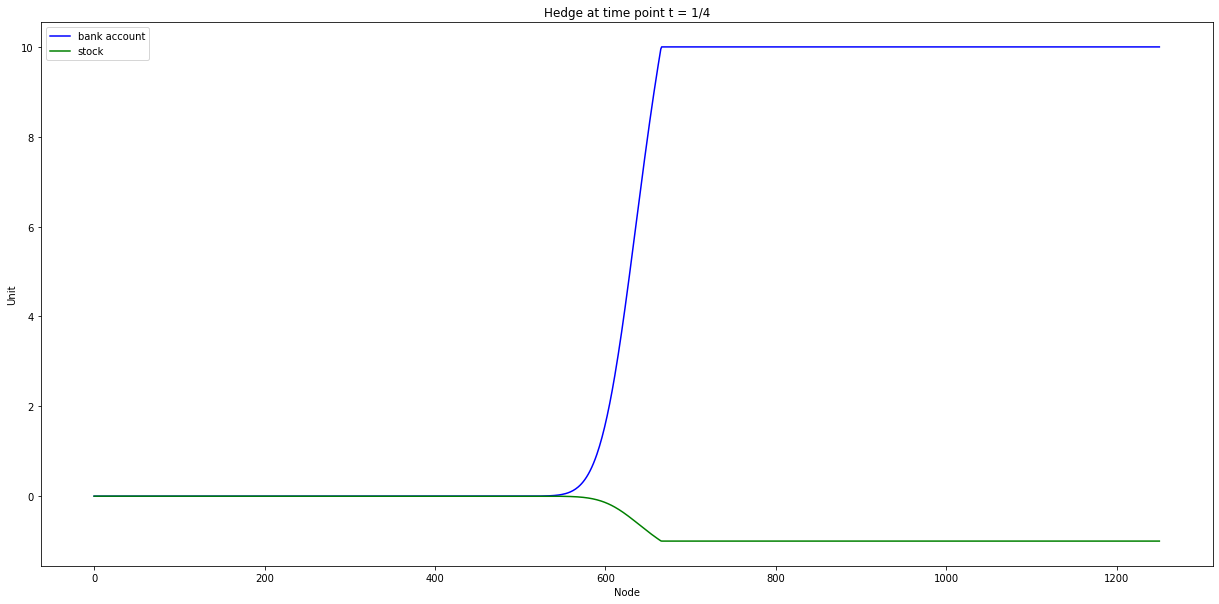

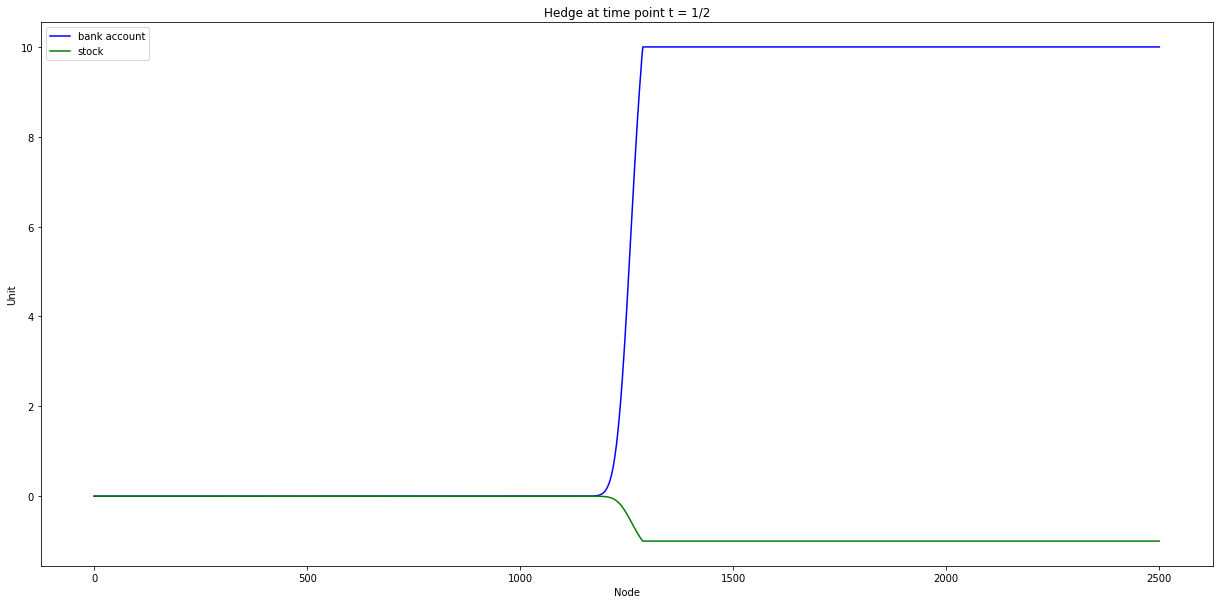

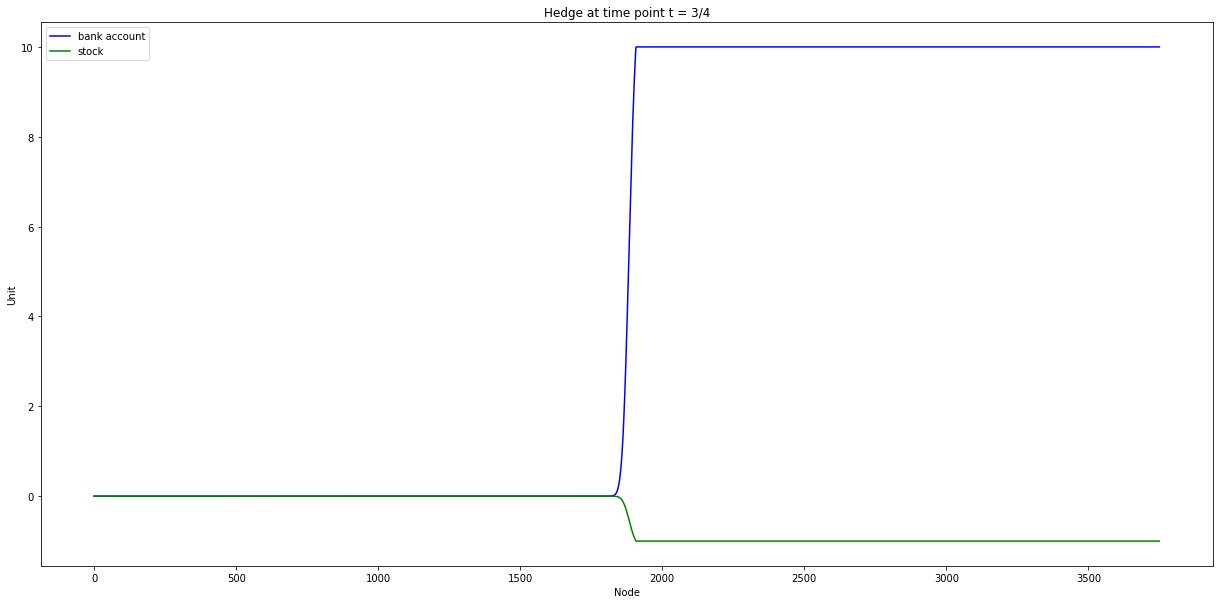

In [20]:
HedgingPlot(sigma_0_ame__01, sigma_1_ame__01, 5000)

[5.067940012198002, -0.4356819574412066]


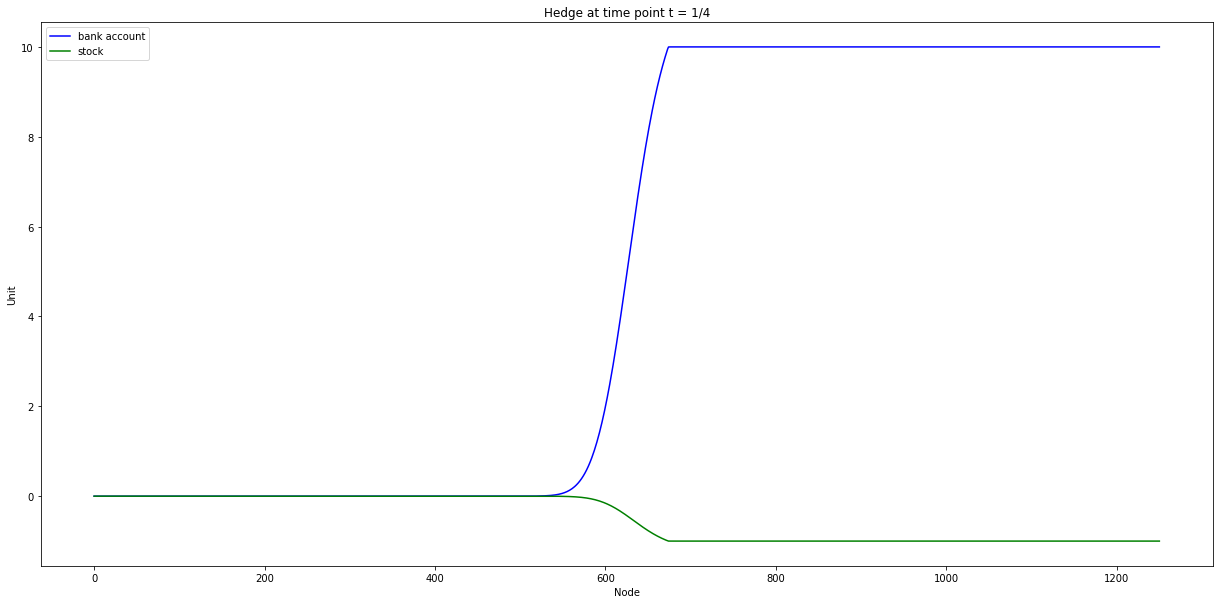

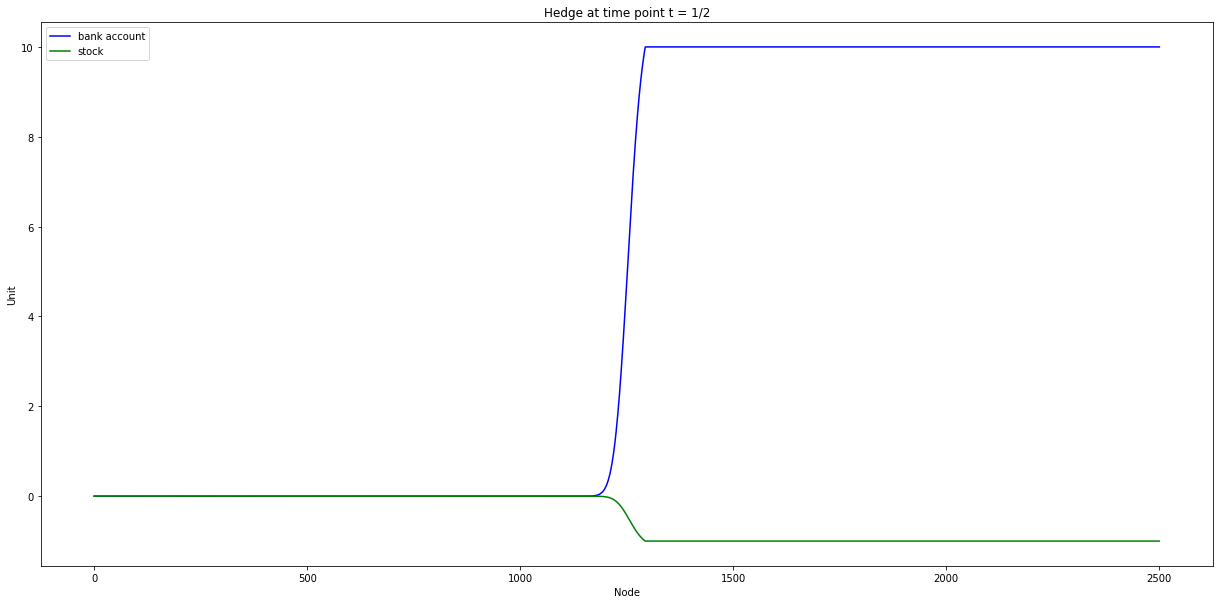

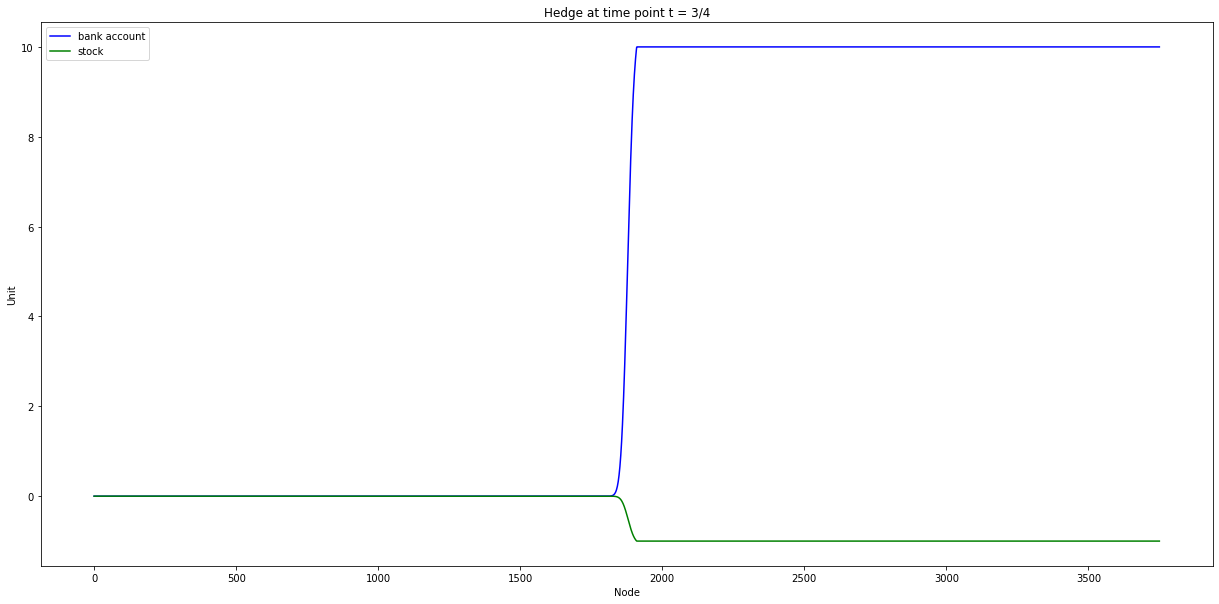

In [21]:
HedgingPlot(sigma_0_ame__02, sigma_1_ame__02, 5000)

[5.337990566212365, -0.4236614111975203]


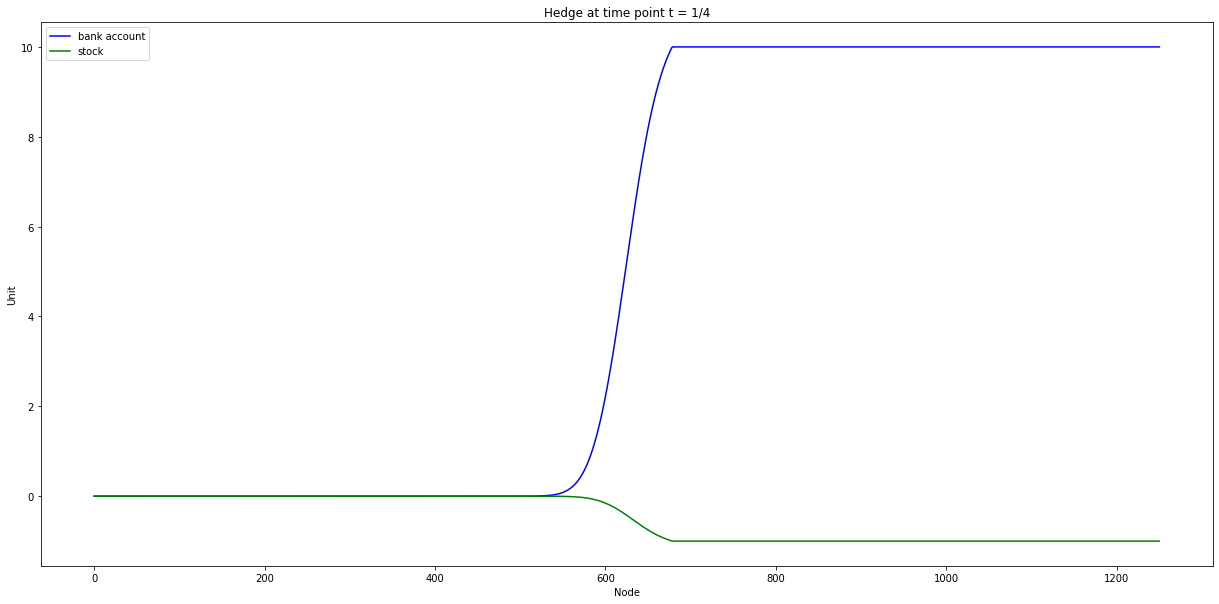

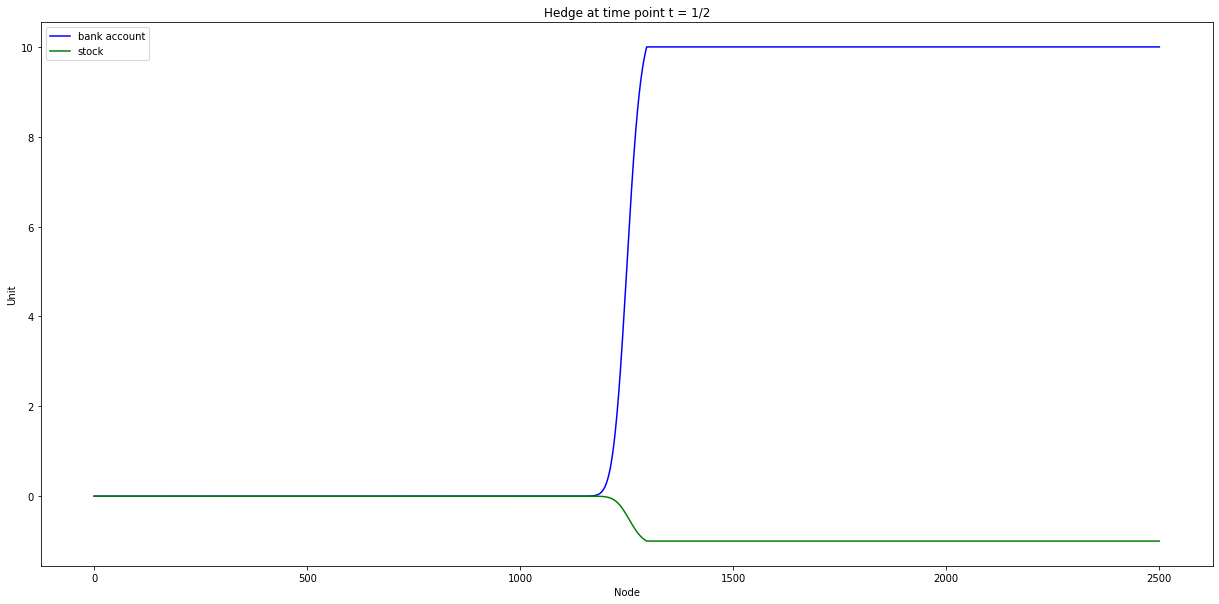

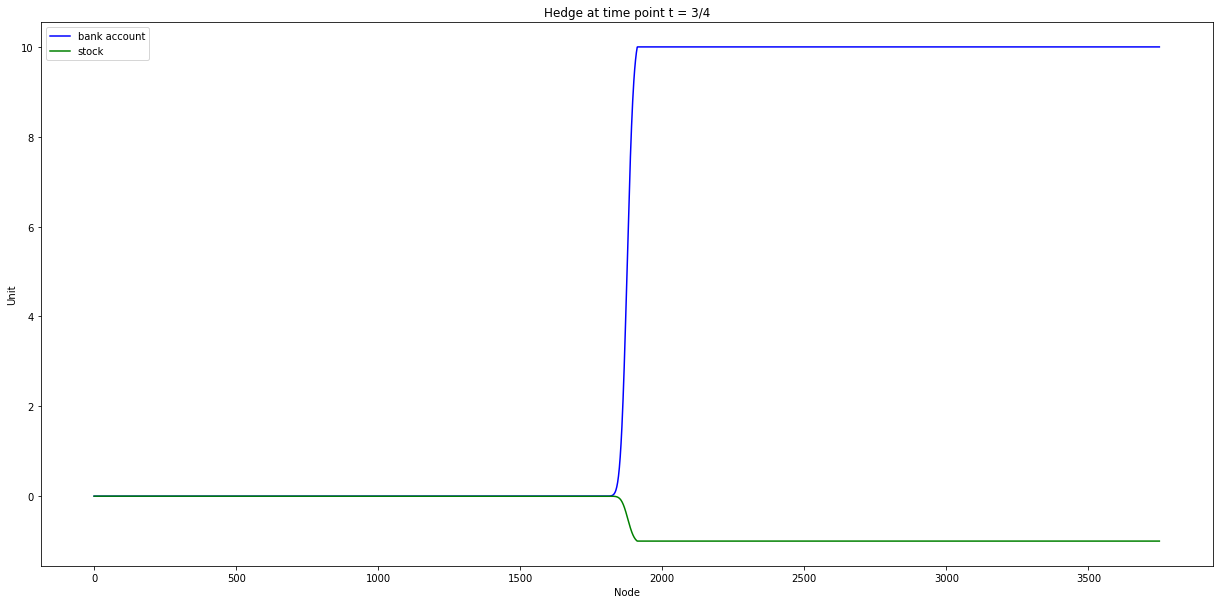

In [22]:
HedgingPlot(sigma_0_ame__03, sigma_1_ame__03, 5000)

[5.789367347454734, -0.39144438813055243]


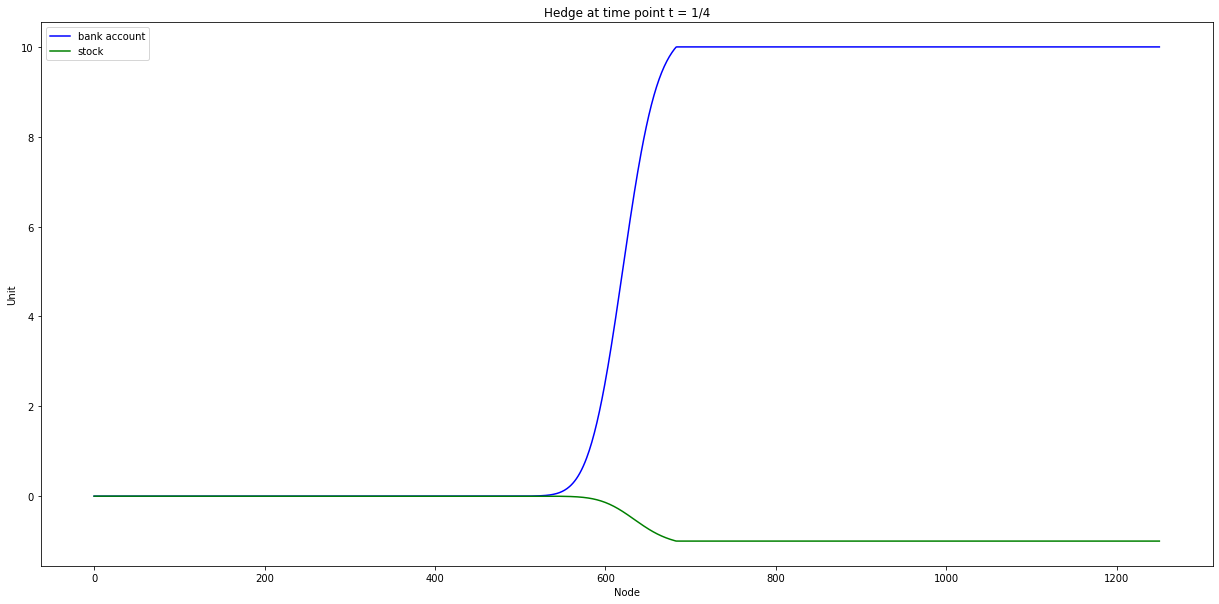

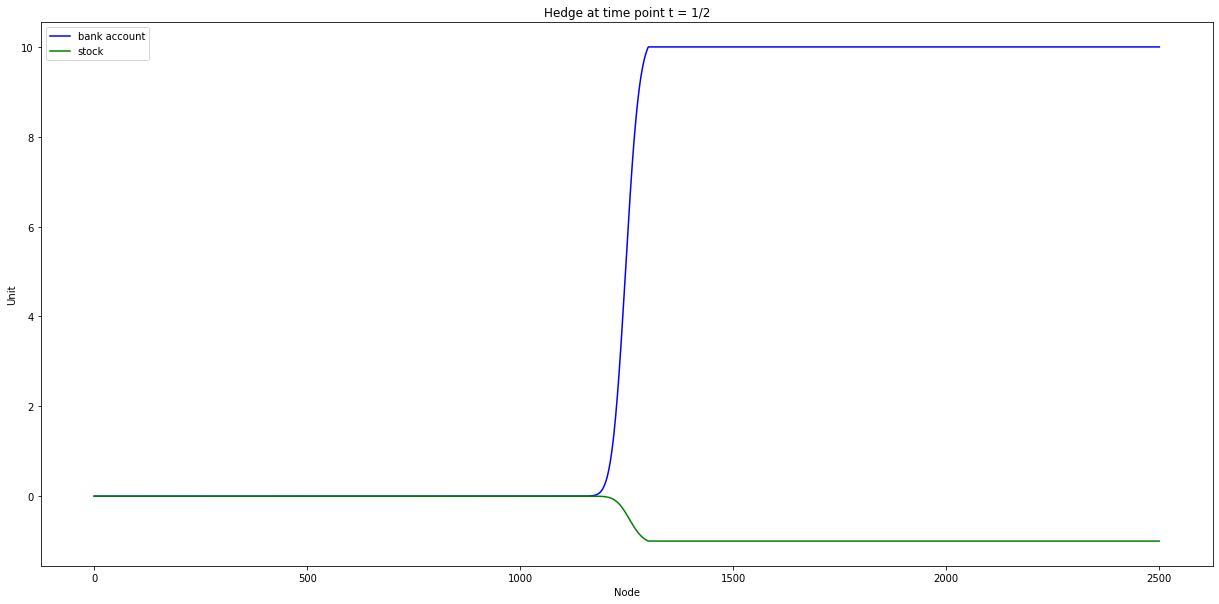

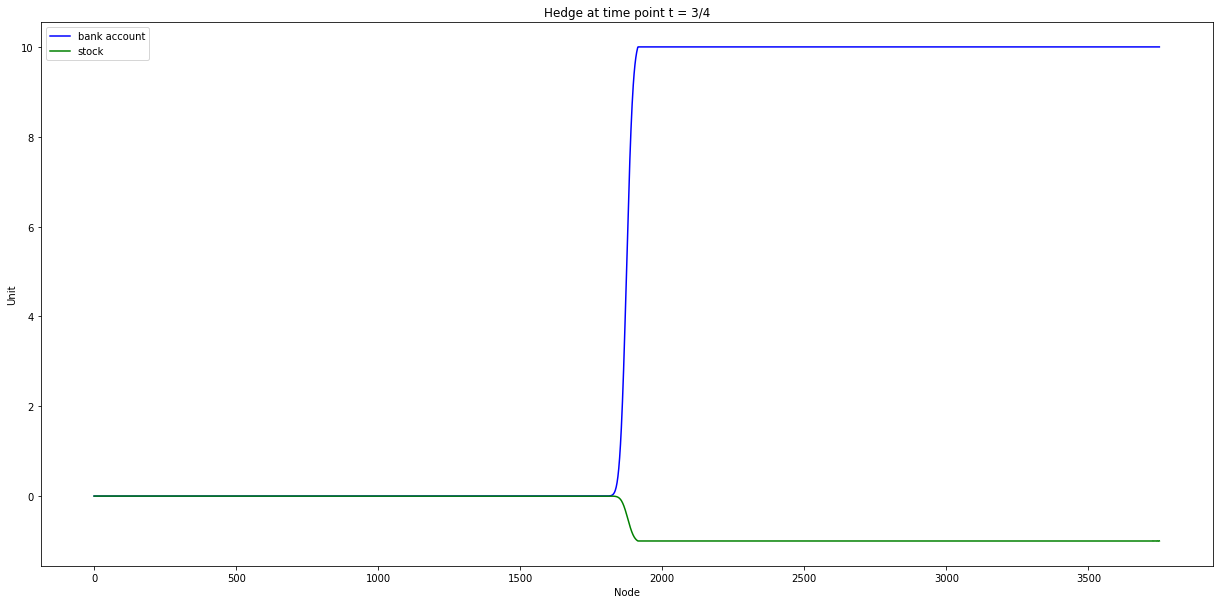

In [23]:
HedgingPlot(sigma_0_ame__05, sigma_1_ame__05, 5000)

[6.196138808513723, -0.35656837216891163]


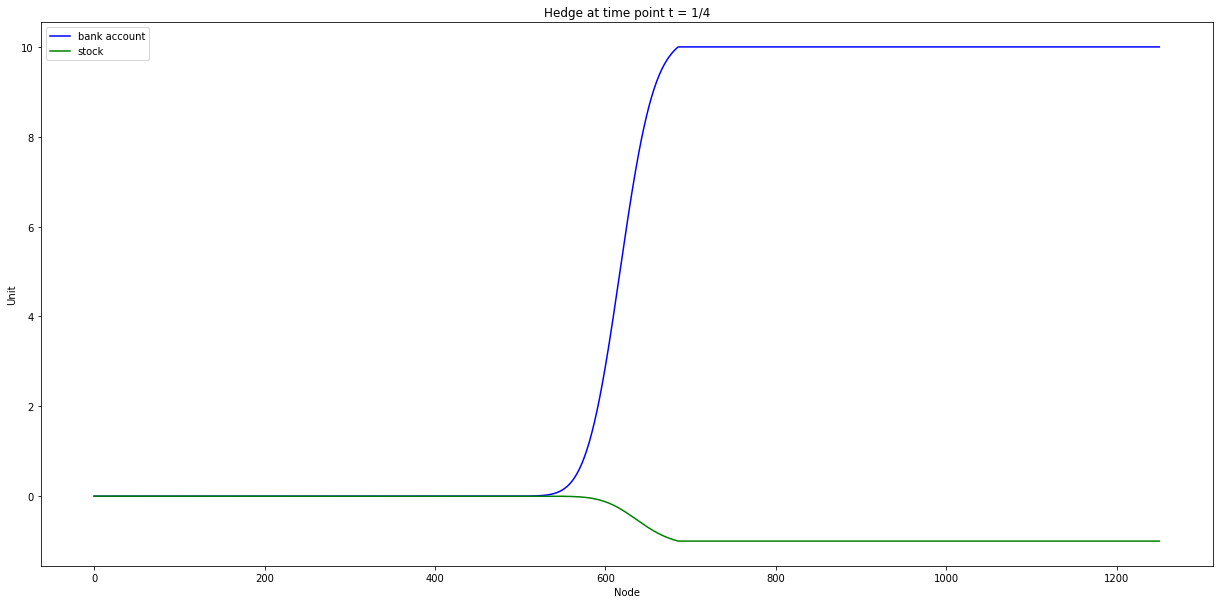

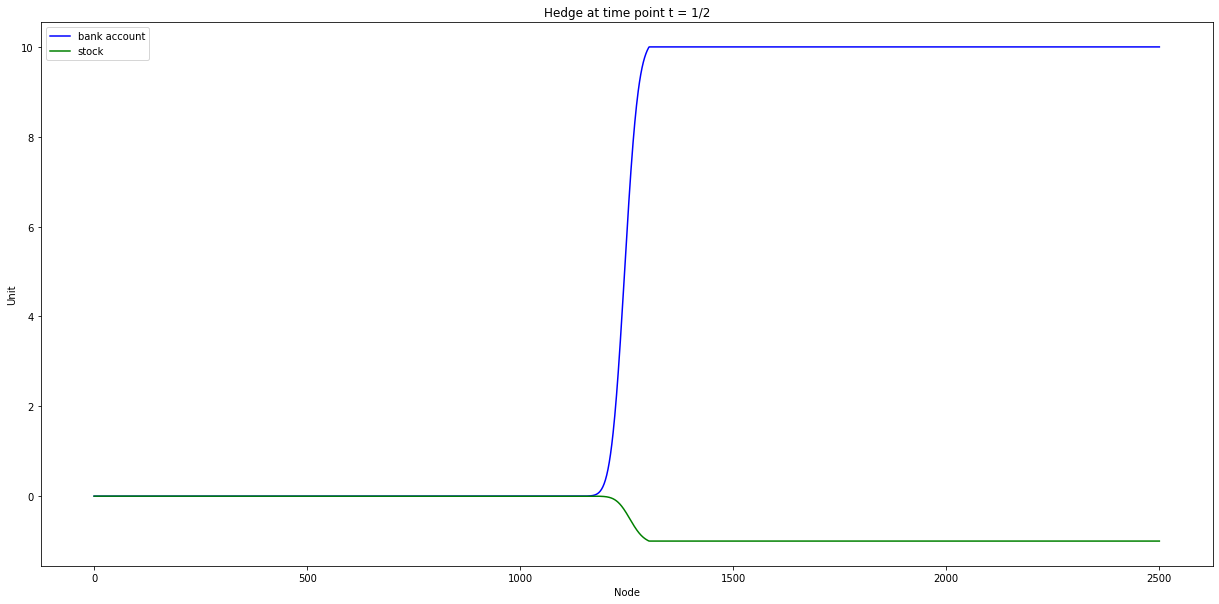

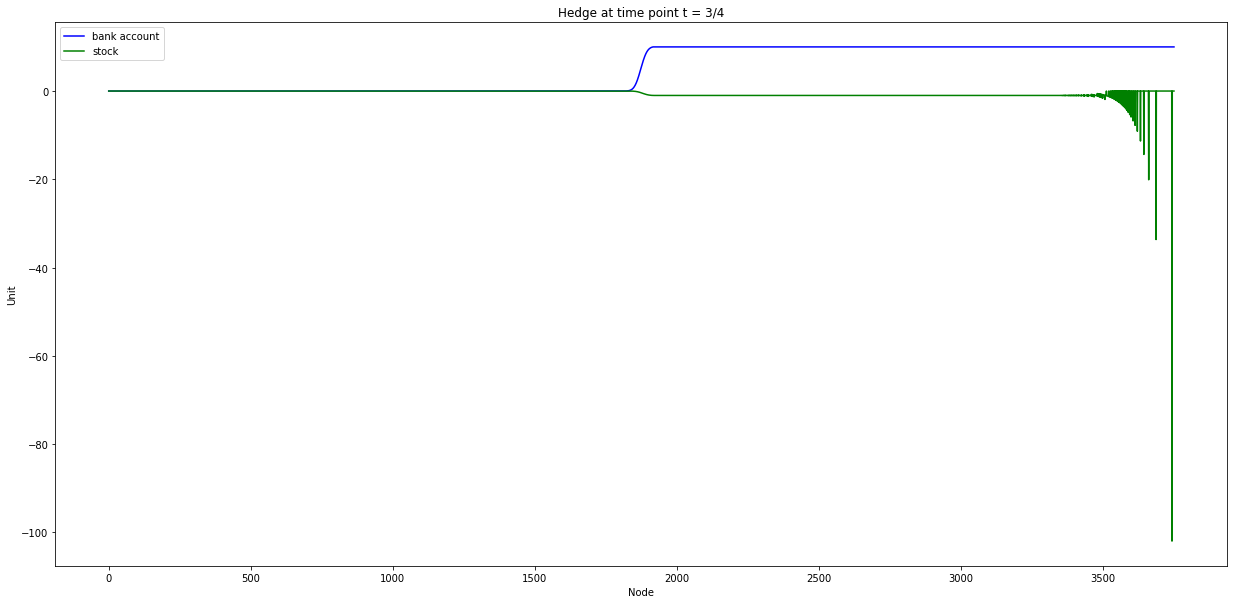

In [24]:
HedgingPlot(sigma_0_ame__07, sigma_1_ame__07, 5000)

[6.577796394934152, -0.32167909679157647]


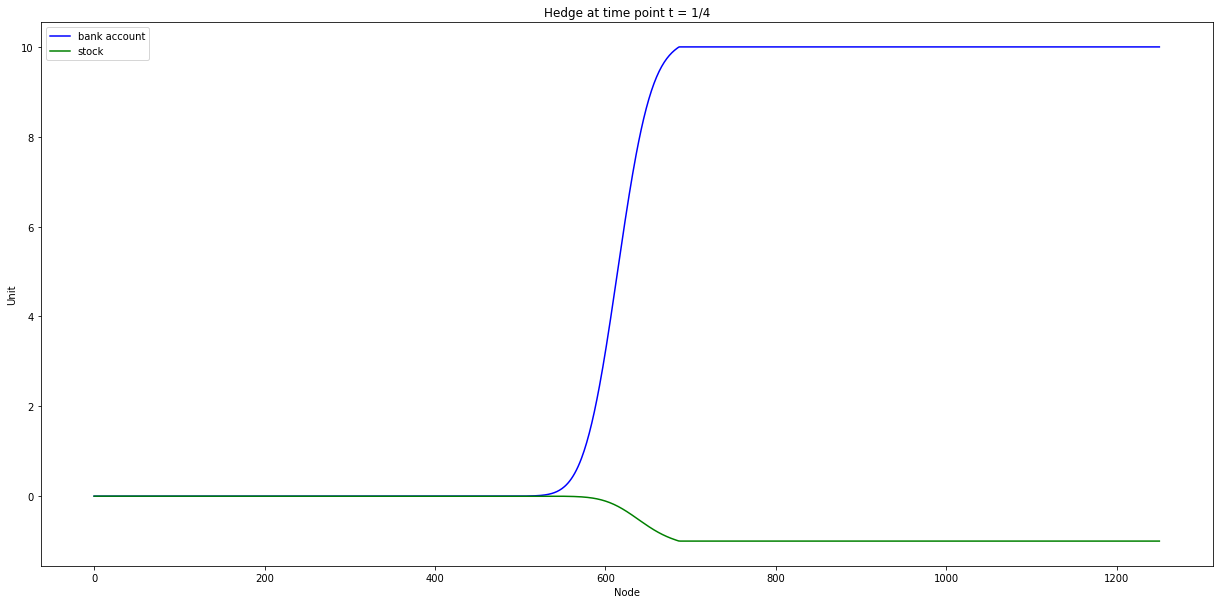

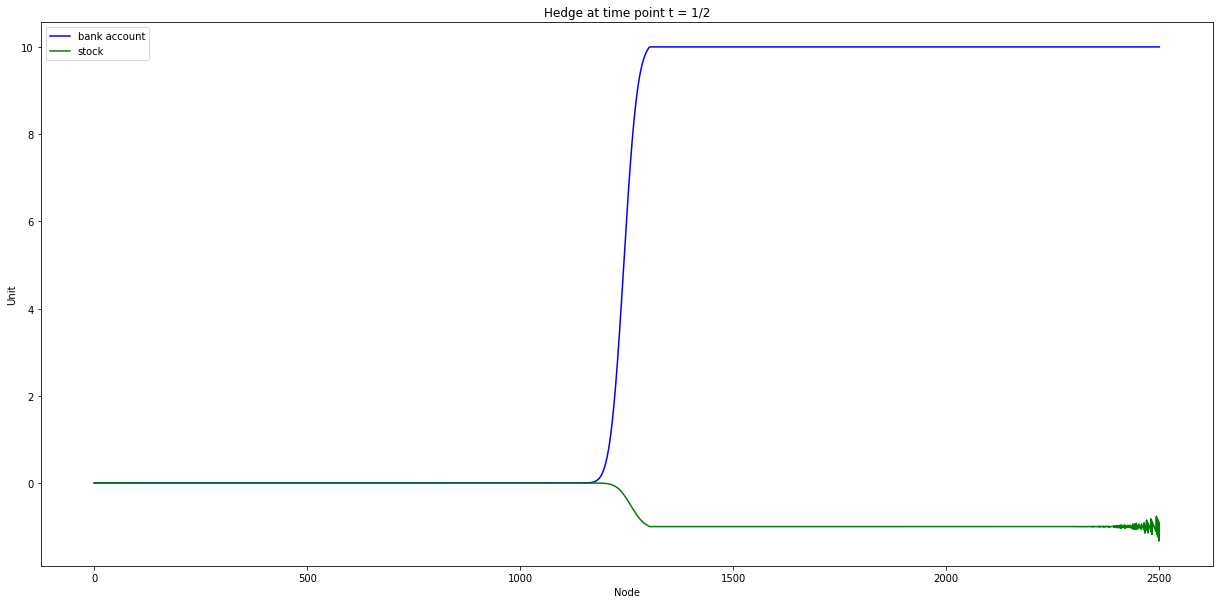

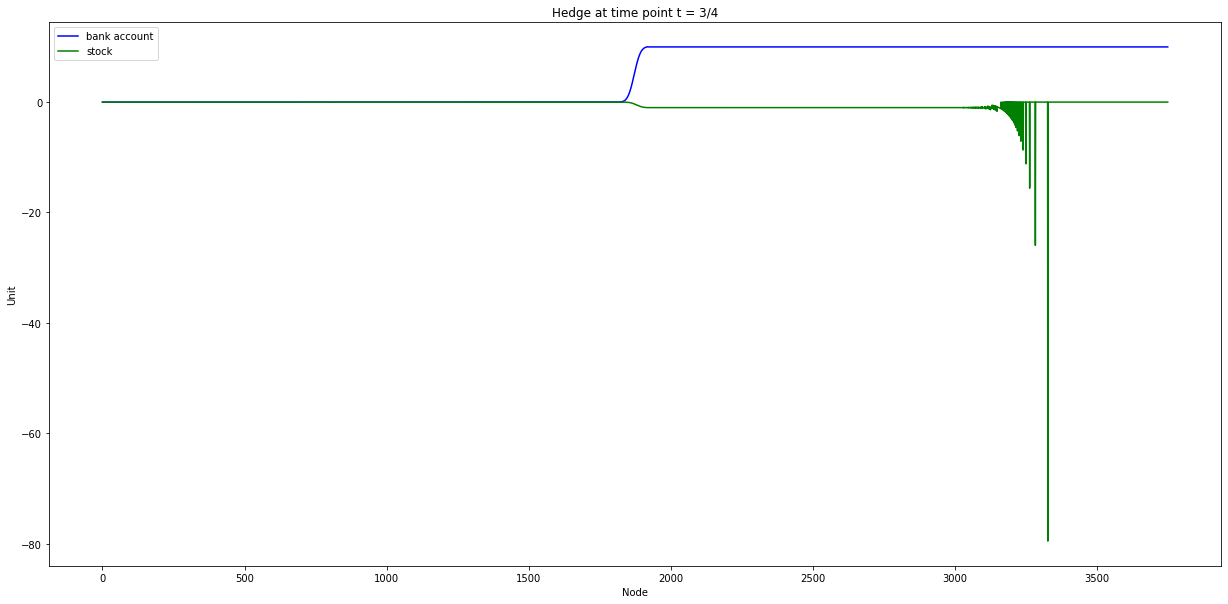

In [25]:
HedgingPlot(sigma_0_ame__09, sigma_1_ame__09, 5000)

European Plot

[4.316573047804866, -0.4012897667130342]


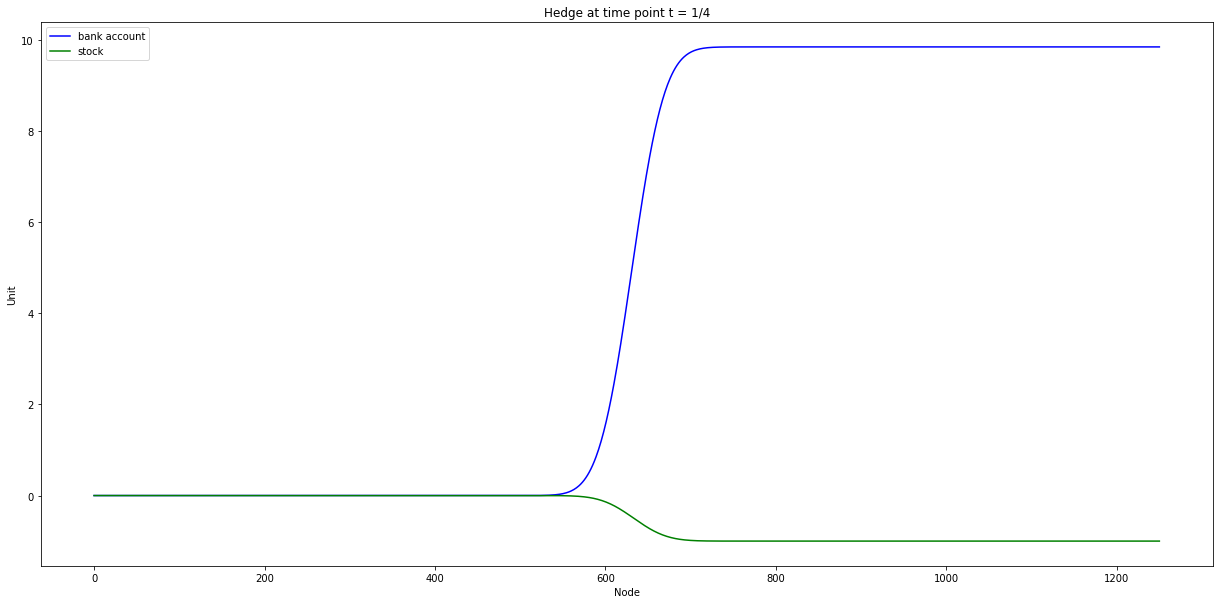

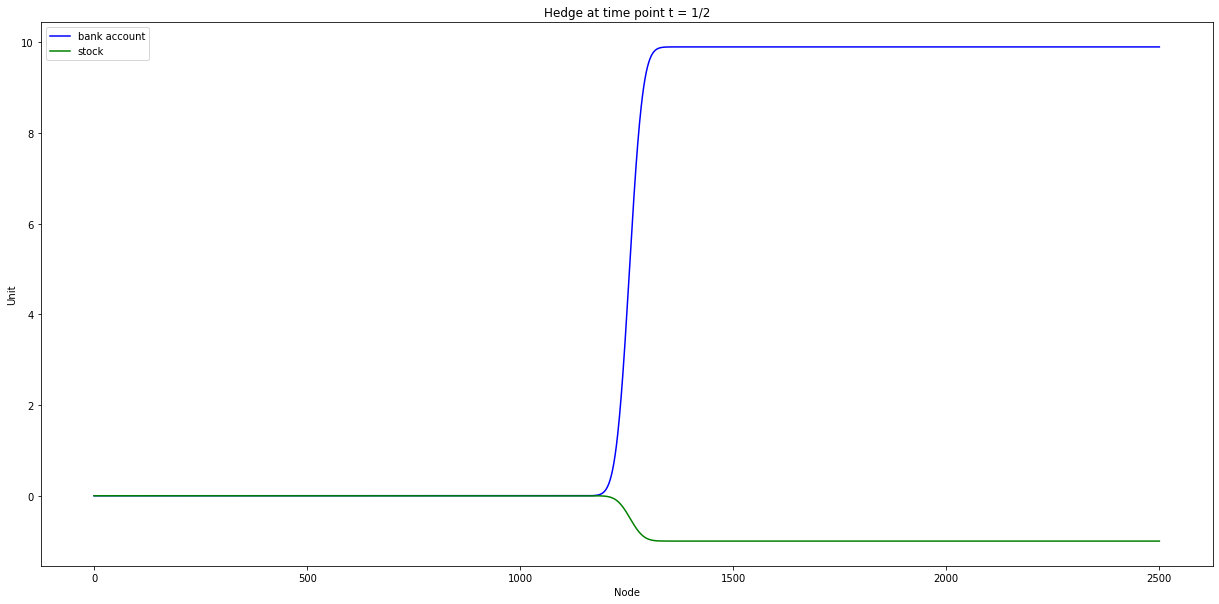

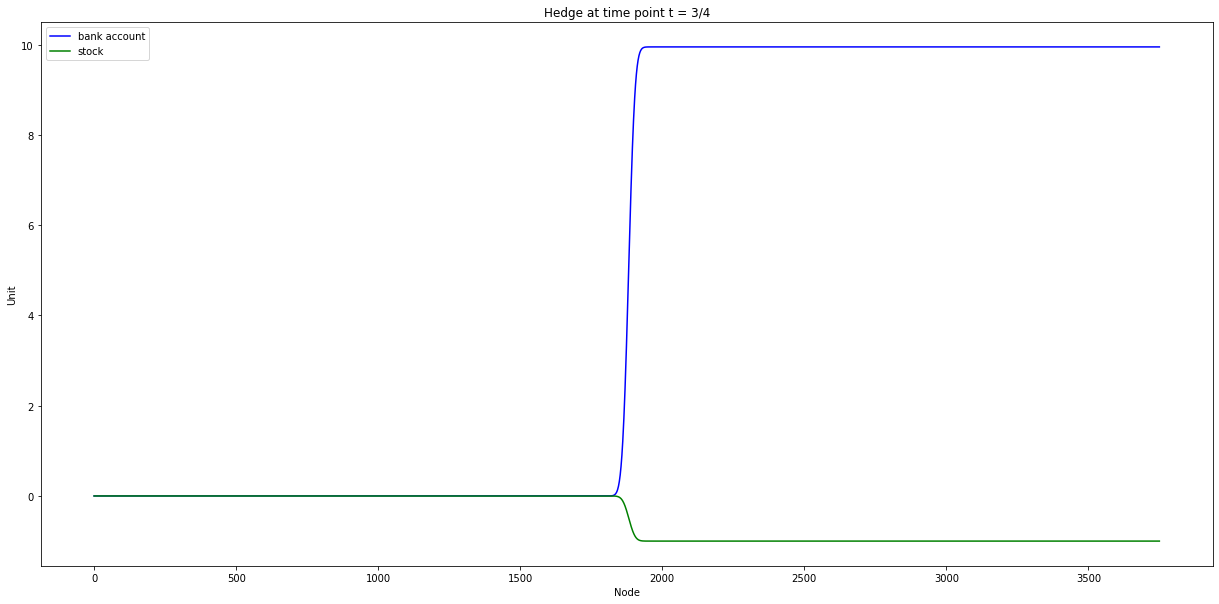

In [26]:
HedgingPlot(sigma_0_eur__01, sigma_1_eur__01, 5000)

[4.9010185271496285, -0.42073896114772186]


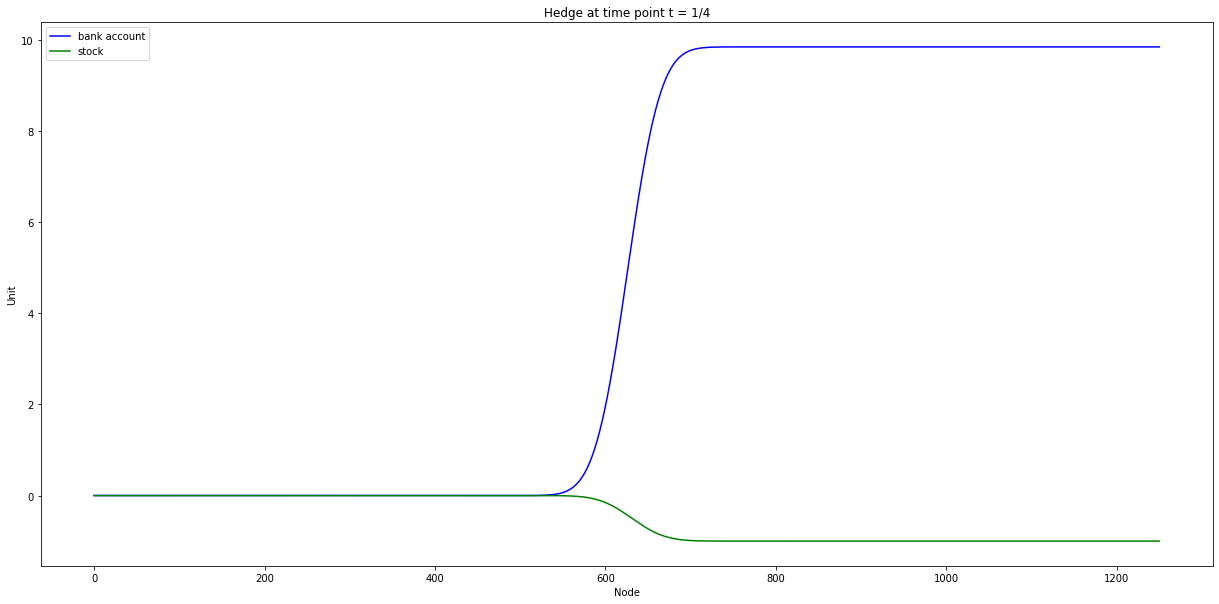

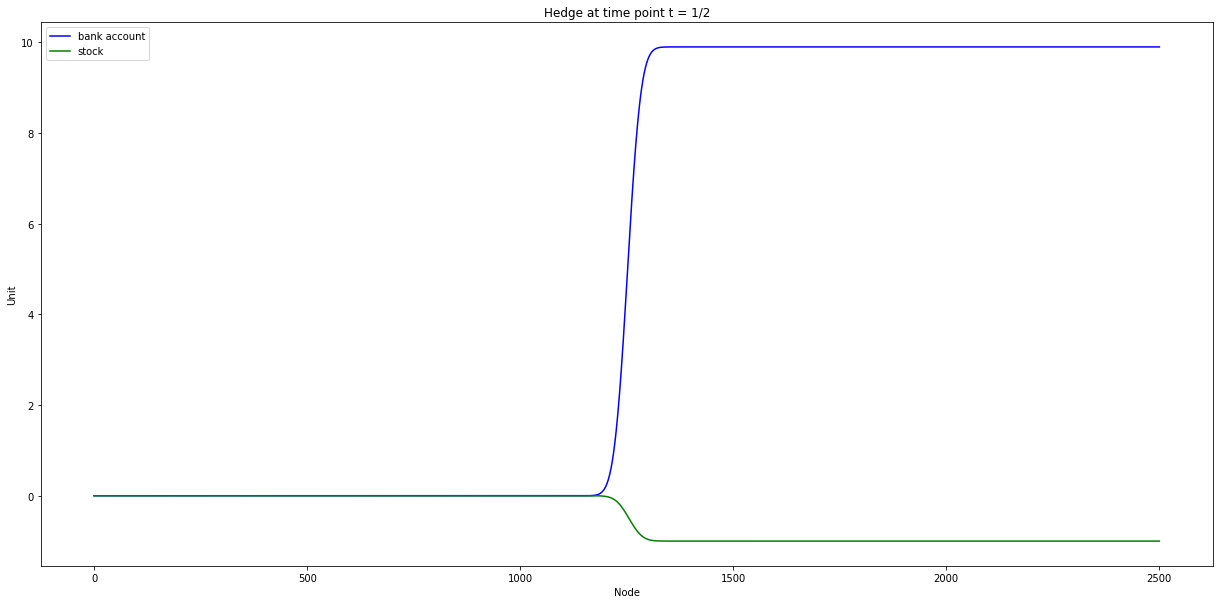

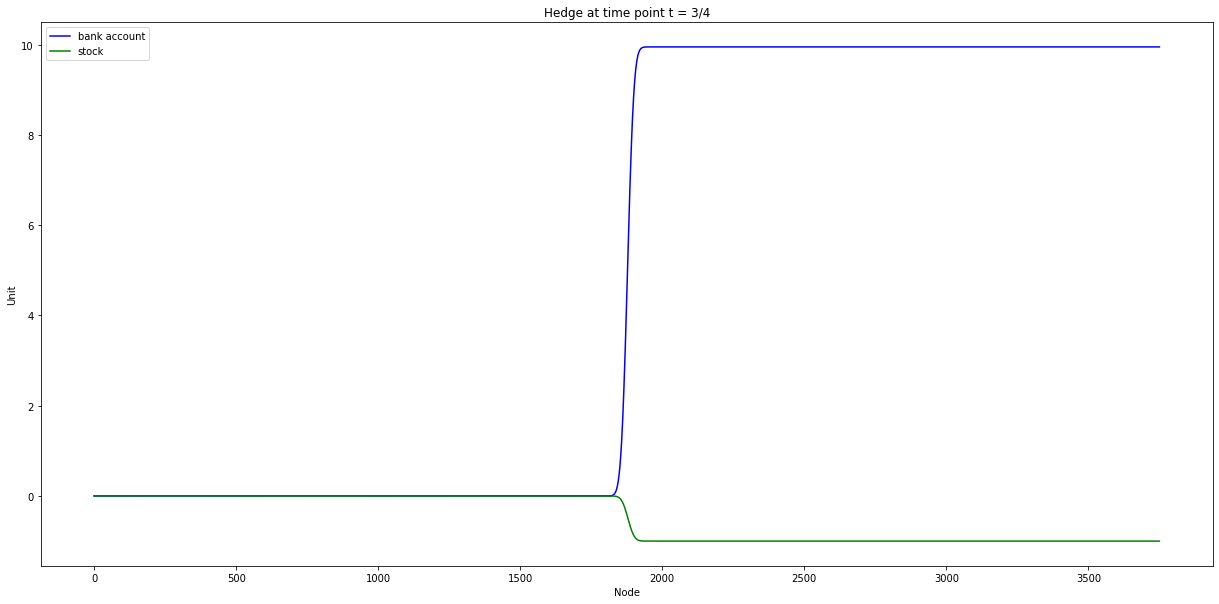

In [27]:
HedgingPlot(sigma_0_eur__02, sigma_1_eur__02, 5000)

[5.226512732930285, -0.4142319510219048]


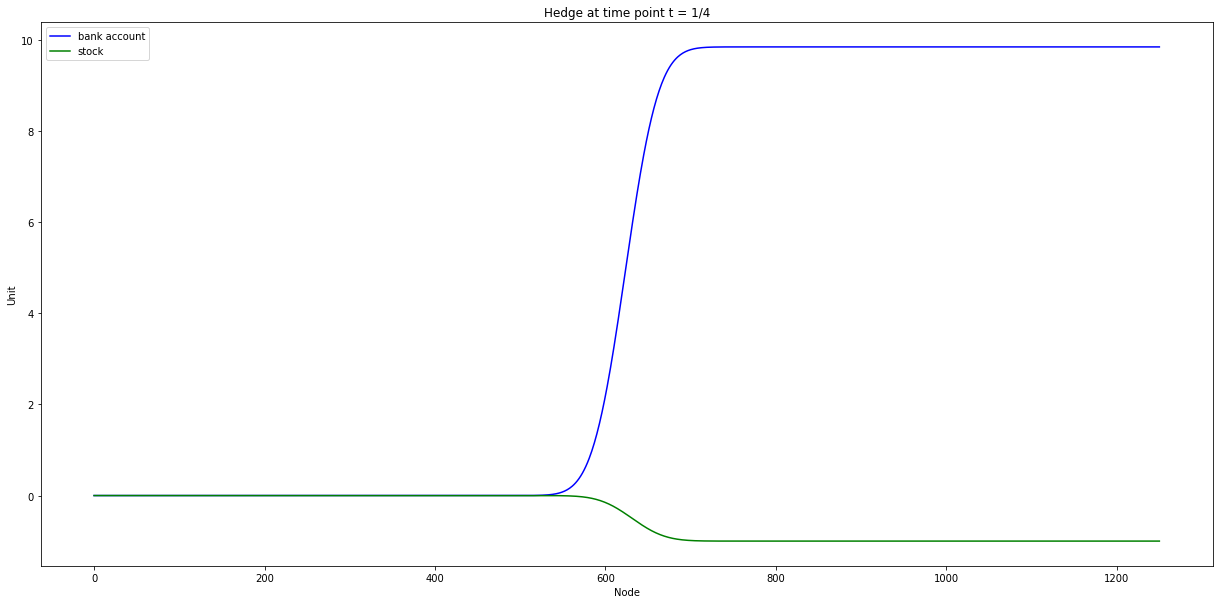

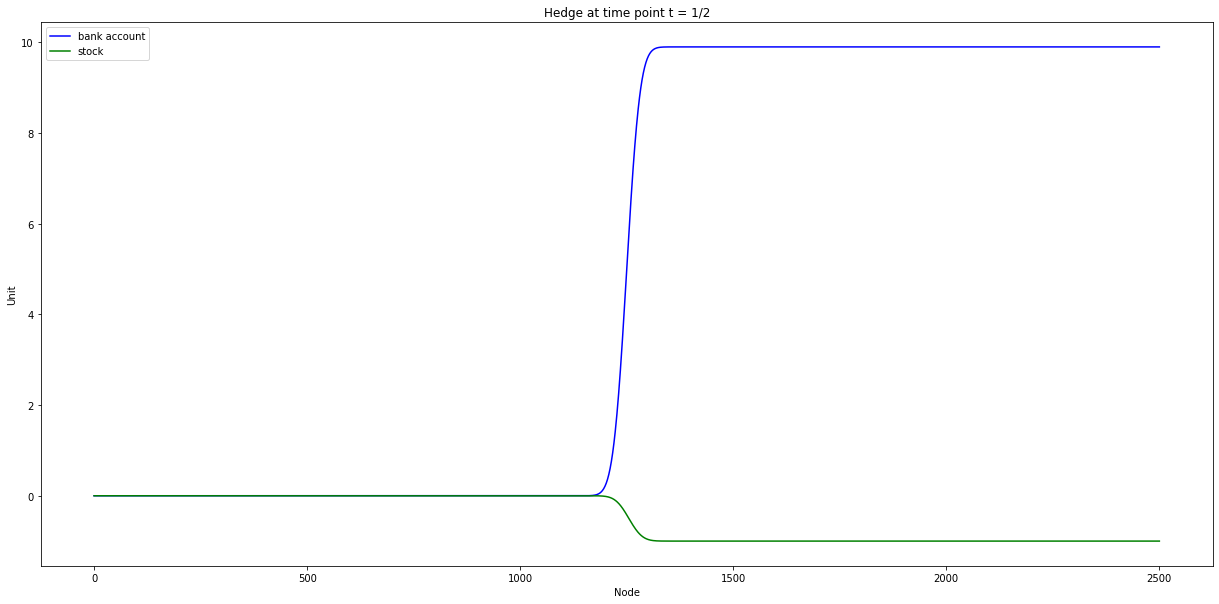

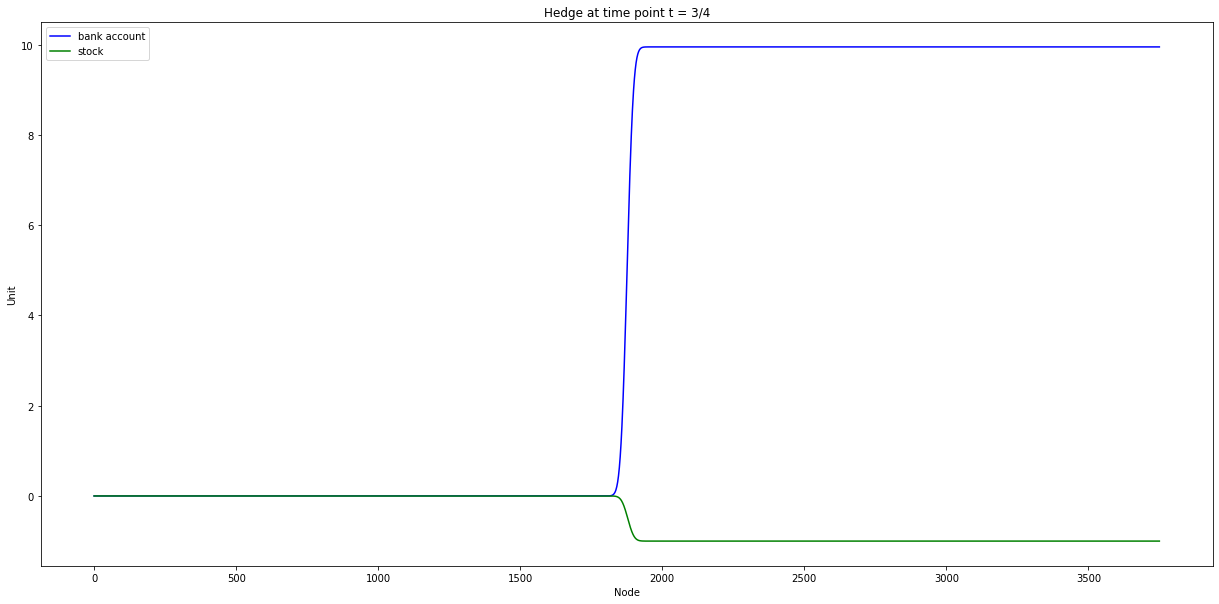

In [28]:
HedgingPlot(sigma_0_eur__03, sigma_1_eur__03, 5000)

[5.716233506762927, -0.38590397518705927]


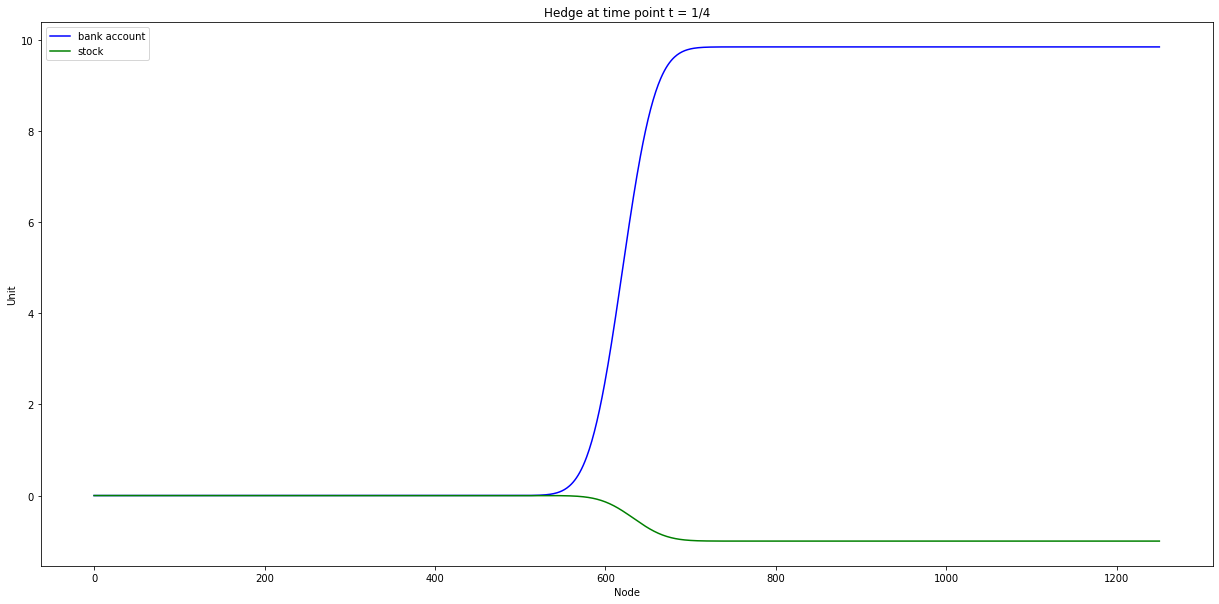

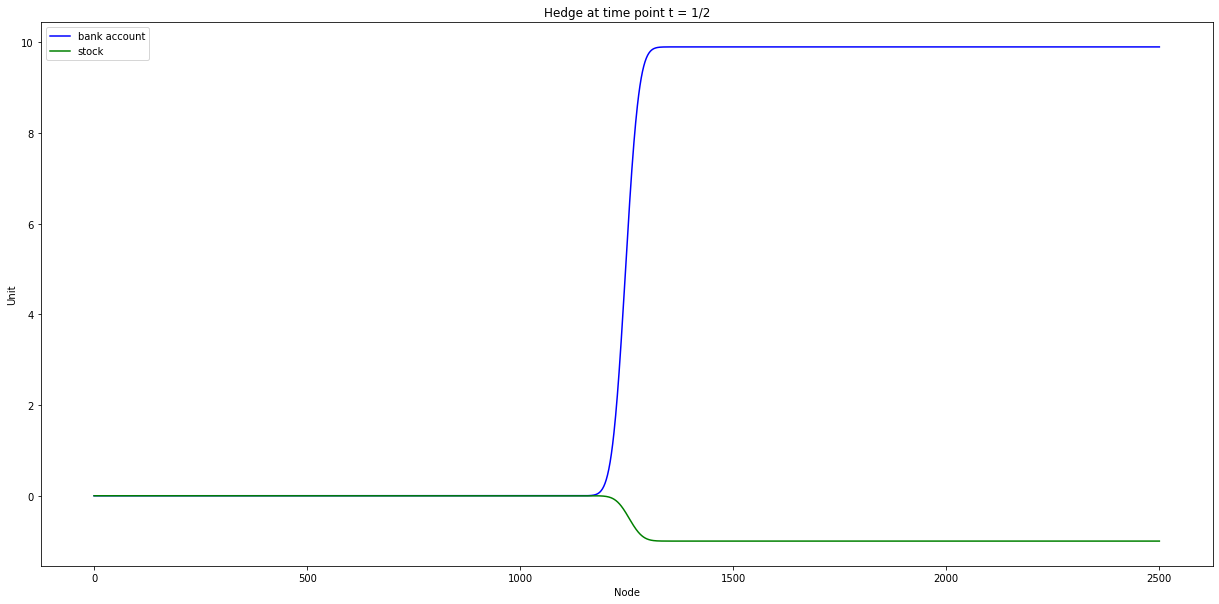

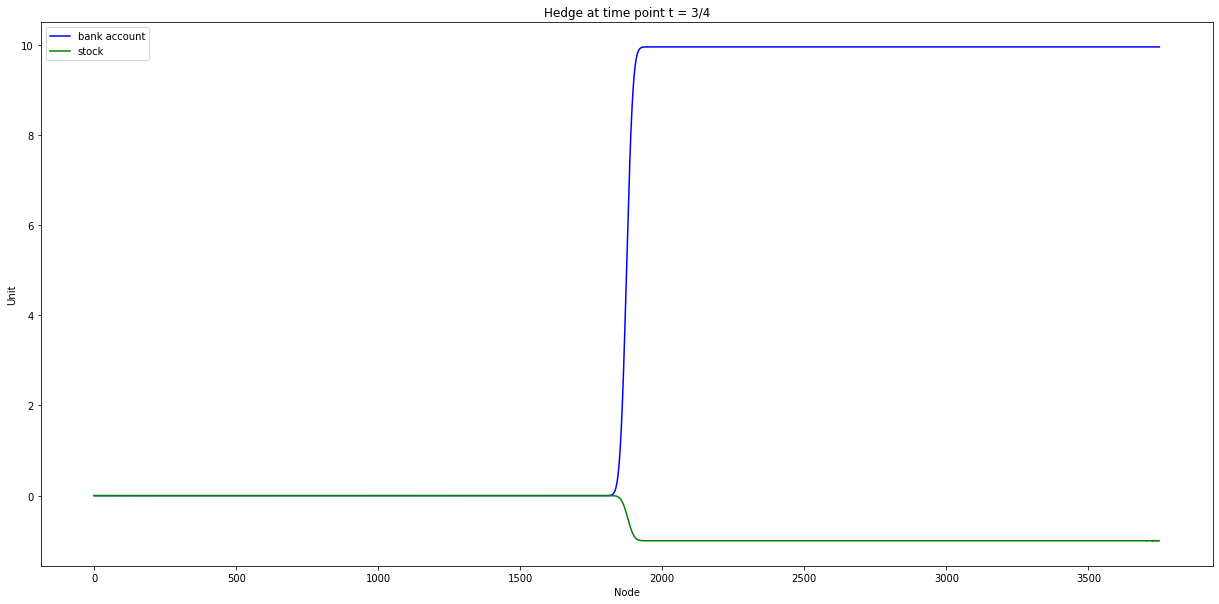

In [29]:
HedgingPlot(sigma_0_eur__05, sigma_1_eur__05, 5000)

[6.13653327174797, -0.3525084649178056]


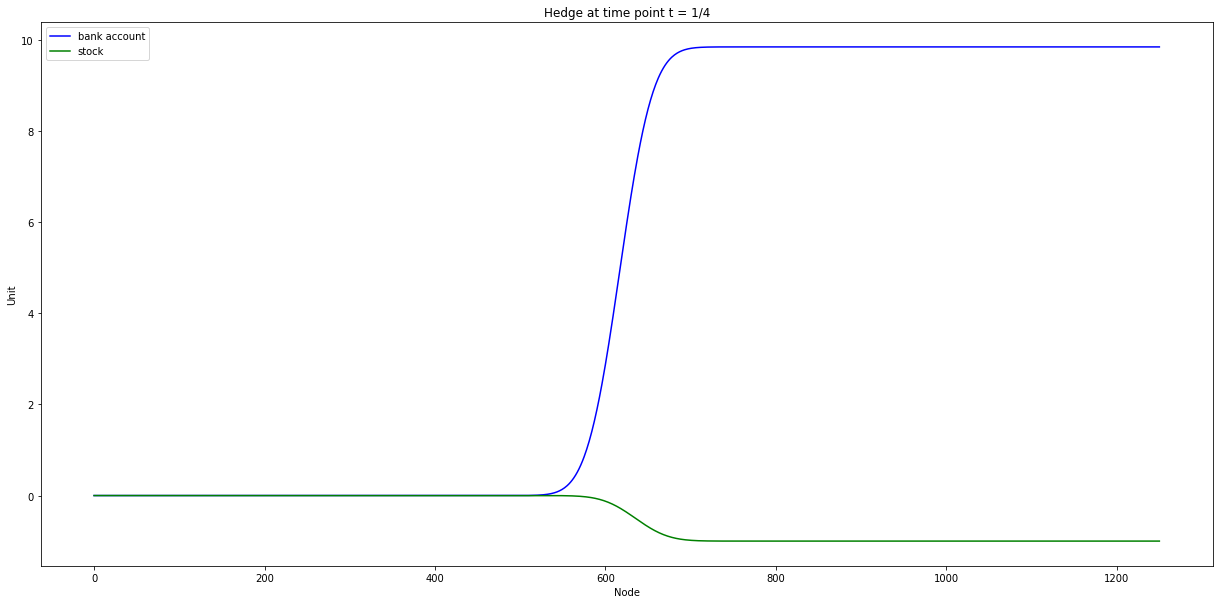

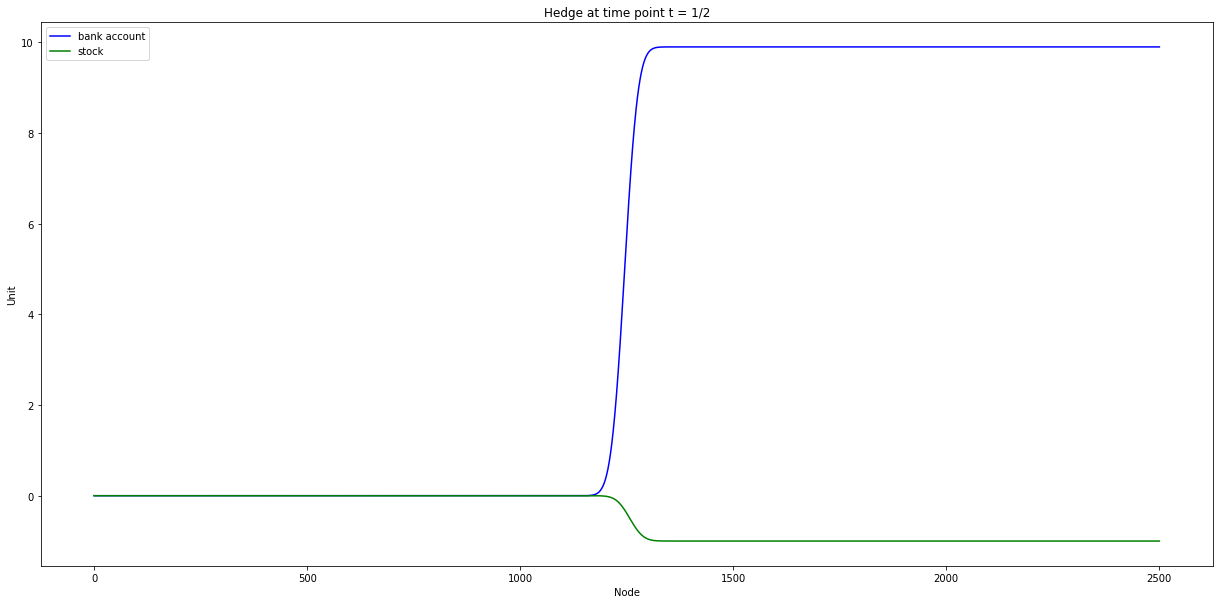

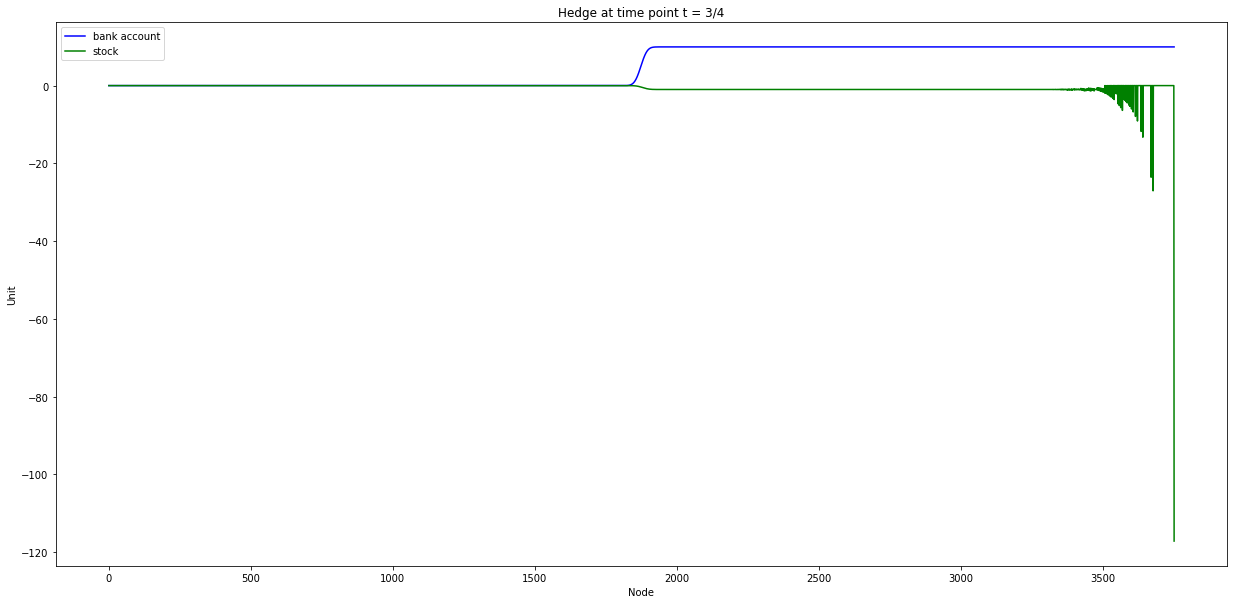

In [30]:
HedgingPlot(sigma_0_eur__07, sigma_1_eur__07, 5000)

[6.524158683380809, -0.31838156170581683]


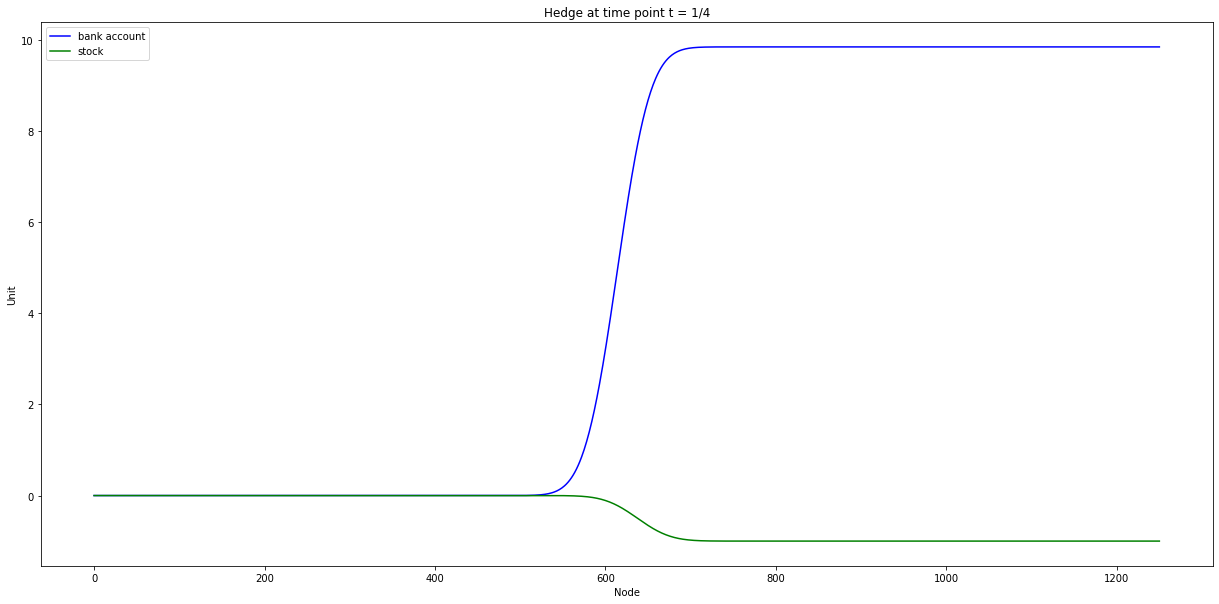

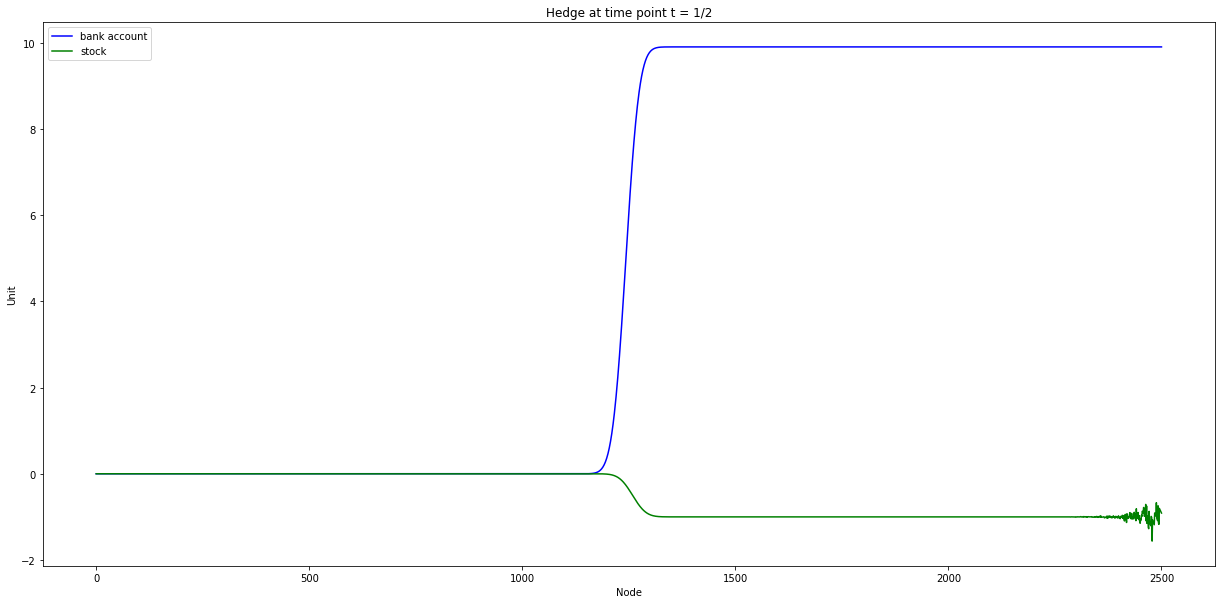

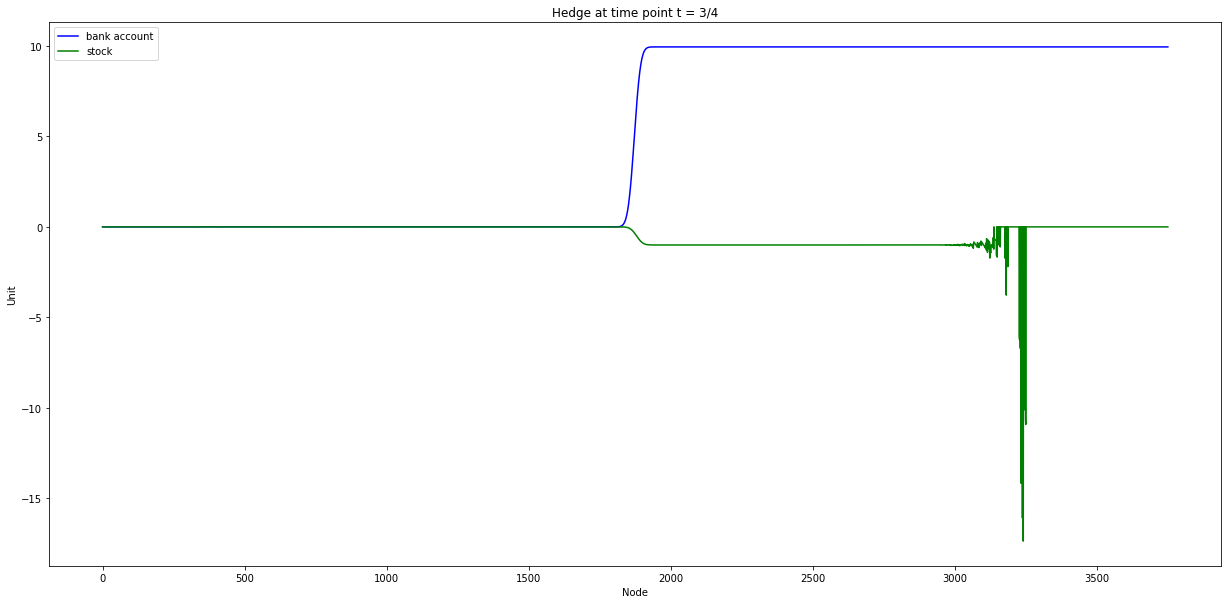

In [31]:
HedgingPlot(sigma_0_eur__09, sigma_1_eur__09, 5000)

## Change risk-free rate 0, 0.02, 0.06, 0.08, 0.1

In [32]:
asset_tree_0, option_tree_0, hold_tree_0, intrinsic_tree_0 = AmericanPut(10, 1, 5000, 0, 0.1, 10)
asset_tree_002, option_tree_002, hold_tree_002, intrinsic_tree_002 = AmericanPut(10, 1, 5000, 0.02, 0.2, 10)
asset_tree_006, option_tree_006, hold_tree_006, intrinsic_tree_006 = AmericanPut(10, 1, 5000, 0.06, 0.3, 10)
asset_tree_008, option_tree_008, hold_tree_008, intrinsic_tree_008 = AmericanPut(10, 1, 5000, 0.08, 0.5, 10)
asset_tree_010, option_tree_010, hold_tree_010, intrinsic_tree_010 = AmericanPut(10, 1, 5000, 0.1, 0.7, 10)

In [33]:
euro_tree_0 = Euro_tree(asset_tree_0, 1, 5000, 0, 0.1, 10)
euro_tree_002 = Euro_tree(asset_tree_002, 1, 5000, 0.02, 0.2, 10)
euro_tree_006 = Euro_tree(asset_tree_006, 1, 5000, 0.06, 0.3, 10)
euro_tree_008 = Euro_tree(asset_tree_008, 1, 5000, 0.08, 0.5, 10)
euro_tree_010 = Euro_tree(asset_tree_010, 1, 5000, 0.1, 0.7, 10)

### t = 1

For both American and European put option, at t=1 (the maturity of put option),,

When the asset price >= K (=10), we hold the stock and not exercise the put option.

When the asset price < K (=10), we exercise the put option and short the stock.

In [38]:
asset_tree_0df = pd.DataFrame(asset_tree_0)
print(asset_tree_0df[5000][2500])
print(asset_tree_0df[5000][2501])

10.0
9.971755691066829


For risk-free rate = 0, at t=1, the two adjacent nodes' asste price price > 10 and < 10 are 
node 2500(>10) and node 2501(<10)

In [46]:
asset_tree_002df = pd.DataFrame(asset_tree_002)
print(asset_tree_002df[5000][2503])
print(asset_tree_002df[5000][2504])

10.030340306338369
9.973760316410726


For risk-free rate = 0.02, at t=1, the two adjacent nodes' asste price price > 10 and < 10 are 
node 2503(>10) and node 2504(<10)

In [50]:
asset_tree_006df = pd.DataFrame(asset_tree_006)
print(asset_tree_006df[5000][2507])
print(asset_tree_006df[5000][2508])

10.006032122397034
9.921487324864893


For risk-free rate = 0.06, at t=1, the two adjacent nodes' asste price price > 10 and < 10 are 
node 2507(>10) and node 2508(<10)

In [59]:
asset_tree_008df = pd.DataFrame(asset_tree_008)
print(asset_tree_008df[5000][2505])
print(asset_tree_008df[5000][2506])

10.09332601540945
9.951589421341769


For risk-free rate = 0.08, at t=1, the two adjacent nodes' asste price price > 10 and < 10 are 
node 2505(>10) and node 2506(<10)

In [64]:
asset_tree_010df = pd.DataFrame(asset_tree_010)
print(asset_tree_010df[5000][2505])
print(asset_tree_010df[5000][2506])

10.01005555866519
9.813815656409112


For risk-free rate = 0.1, at t=1, the two adjacent nodes' asste price price > 10 and < 10 are 
node 2505(>10) and node 2506(<10)

### For other time point t = 0, 1/4, 1/2, 3/4

In [65]:
sigma_0_ame__0, sigma_1_ame__0 = HedgingAme(option_tree_0, asset_tree_0, 1, 5000, 0)
sigma_0_ame__002, sigma_1_ame__002 = HedgingAme(option_tree_002, asset_tree_002, 1, 5000, 0.02)
sigma_0_ame__006, sigma_1_ame__006 = HedgingAme(option_tree_006, asset_tree_006, 1, 5000, 0.06)
sigma_0_ame__008, sigma_1_ame__008 = HedgingAme(option_tree_008, asset_tree_008, 1, 5000, 0.08)
sigma_0_ame__010, sigma_1_ame__010 = HedgingAme(option_tree_010, asset_tree_010, 1, 5000, 0.1)

In [66]:
sigma_0_eur__0, sigma_1_eur__0 = HedgingEur(euro_tree_0, asset_tree_0, 1, 5000, 0)
sigma_0_eur__002, sigma_1_eur__002 = HedgingEur(euro_tree_002, asset_tree_002, 1, 5000, 0.02)
sigma_0_eur__006, sigma_1_eur__006 = HedgingEur(euro_tree_006, asset_tree_006, 1, 5000, 0.06)
sigma_0_eur__008, sigma_1_eur__008 = HedgingEur(euro_tree_008, asset_tree_008, 1, 5000, 0.08)
sigma_0_eur__010, sigma_1_eur__010 = HedgingEur(euro_tree_010, asset_tree_010, 1, 5000, 0.1)

American Plot

[5.199378089237182, -0.48006219107684145]


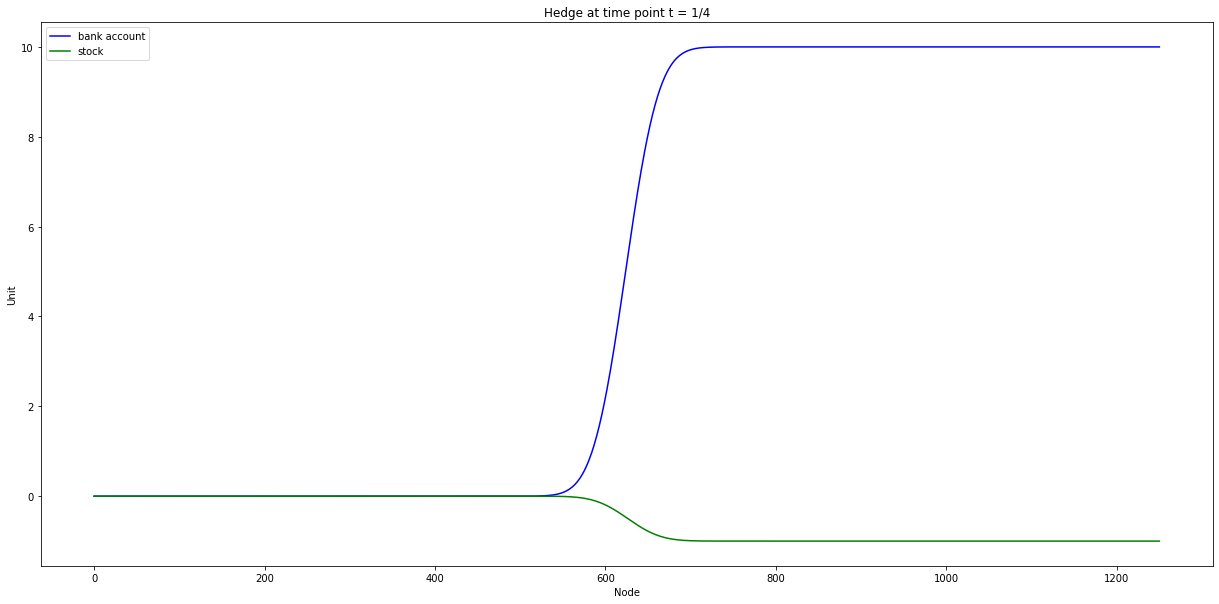

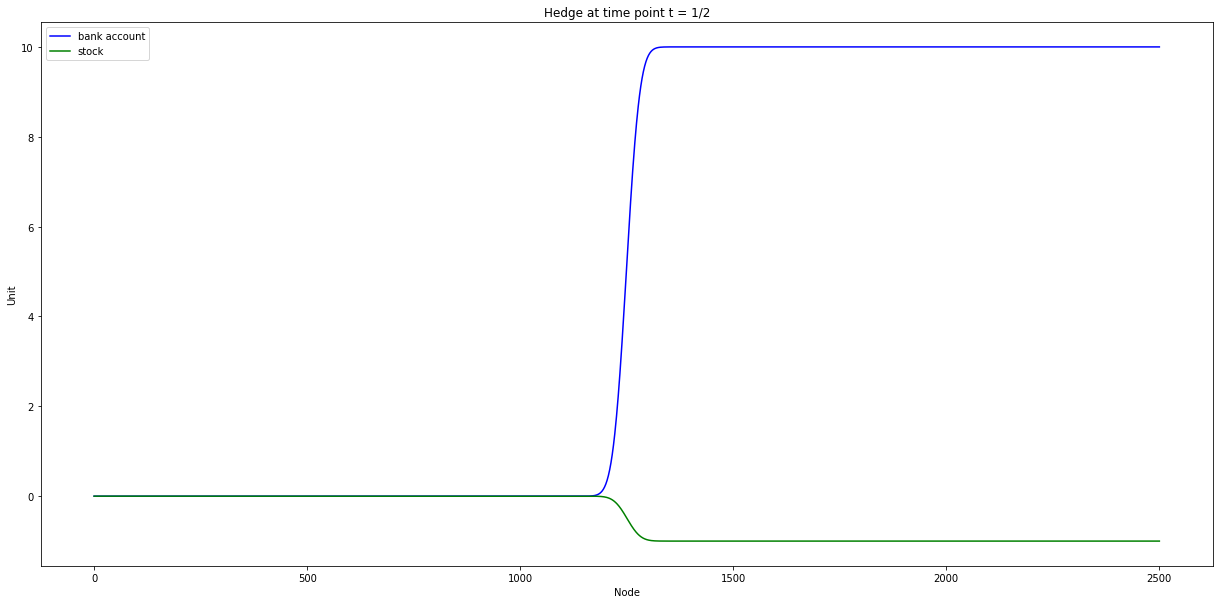

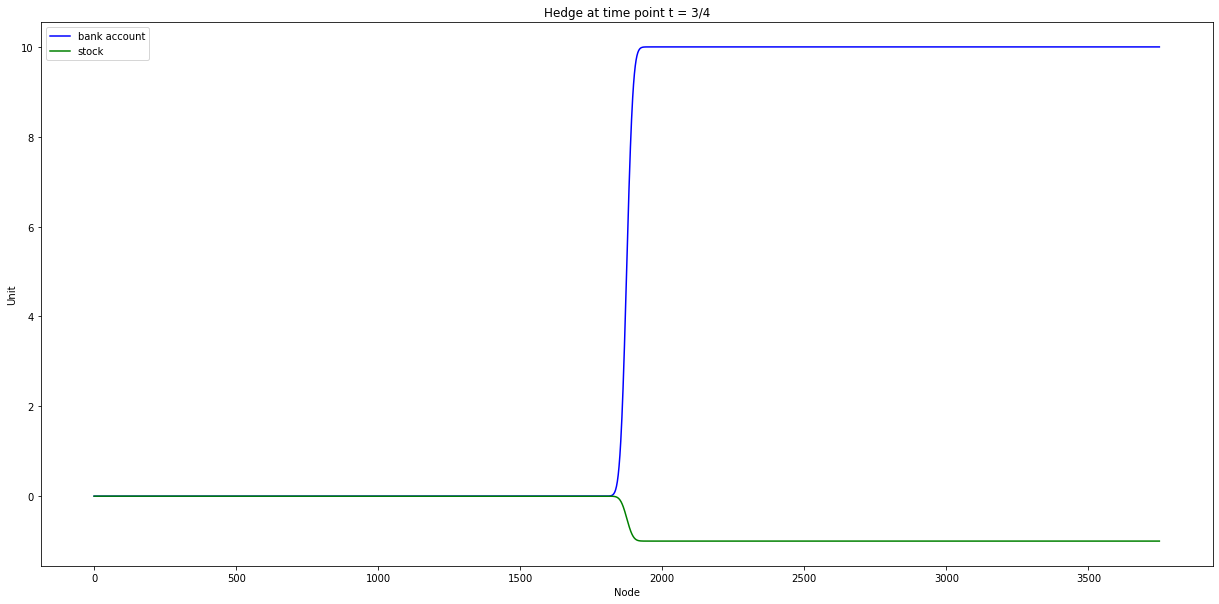

In [67]:
HedgingPlot(sigma_0_ame__0, sigma_1_ame__0, 5000)

[5.067940012198002, -0.4356819574412066]


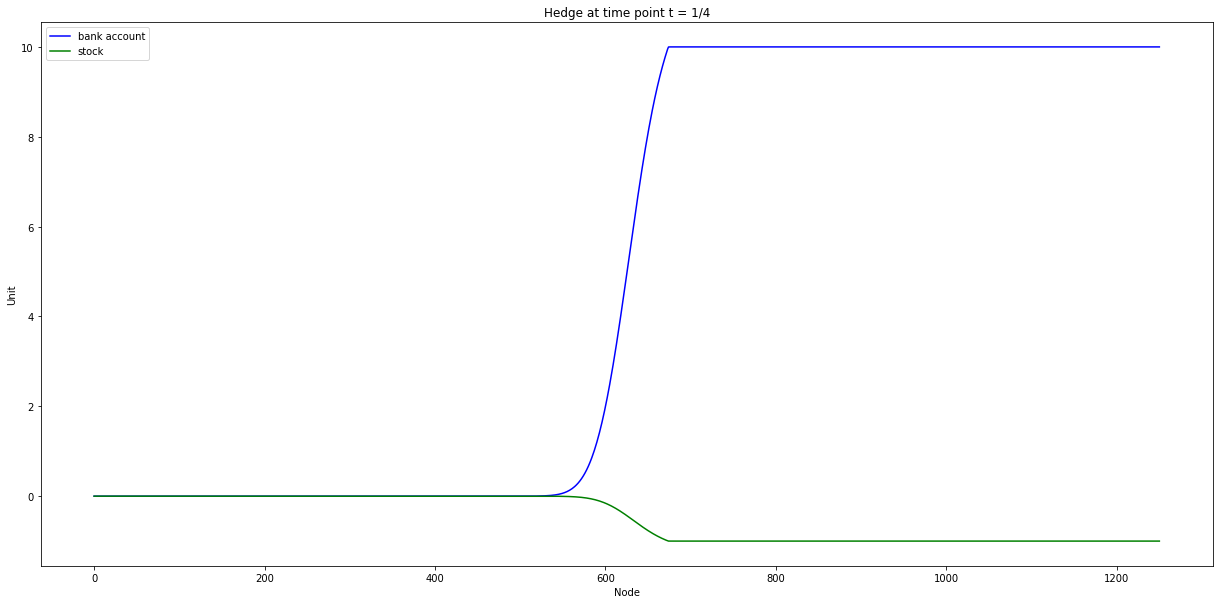

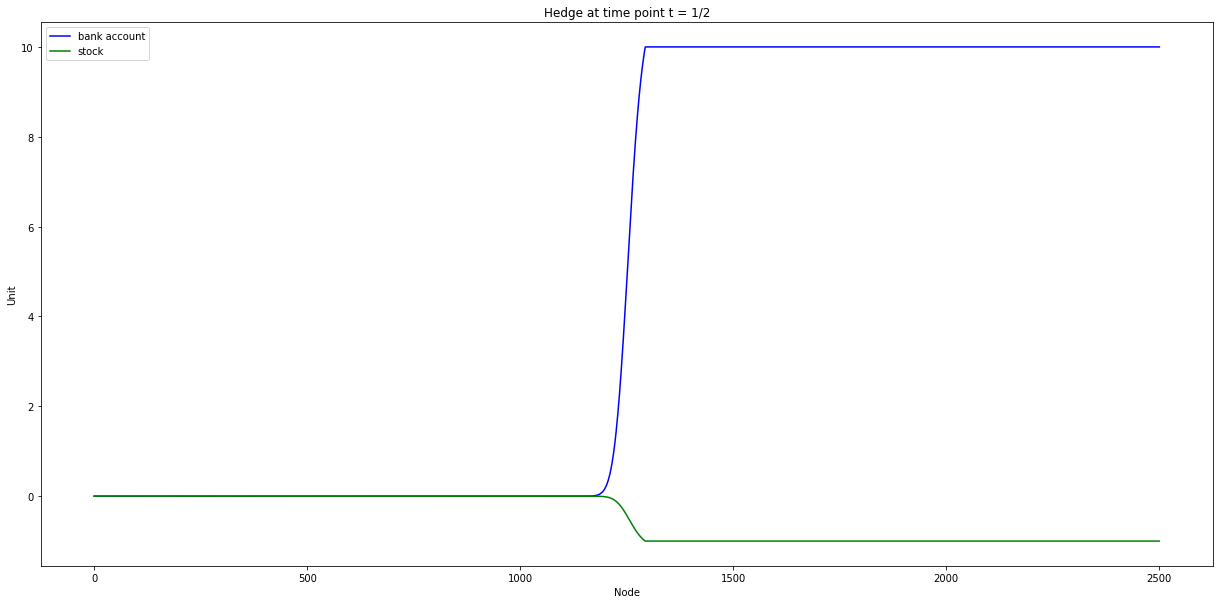

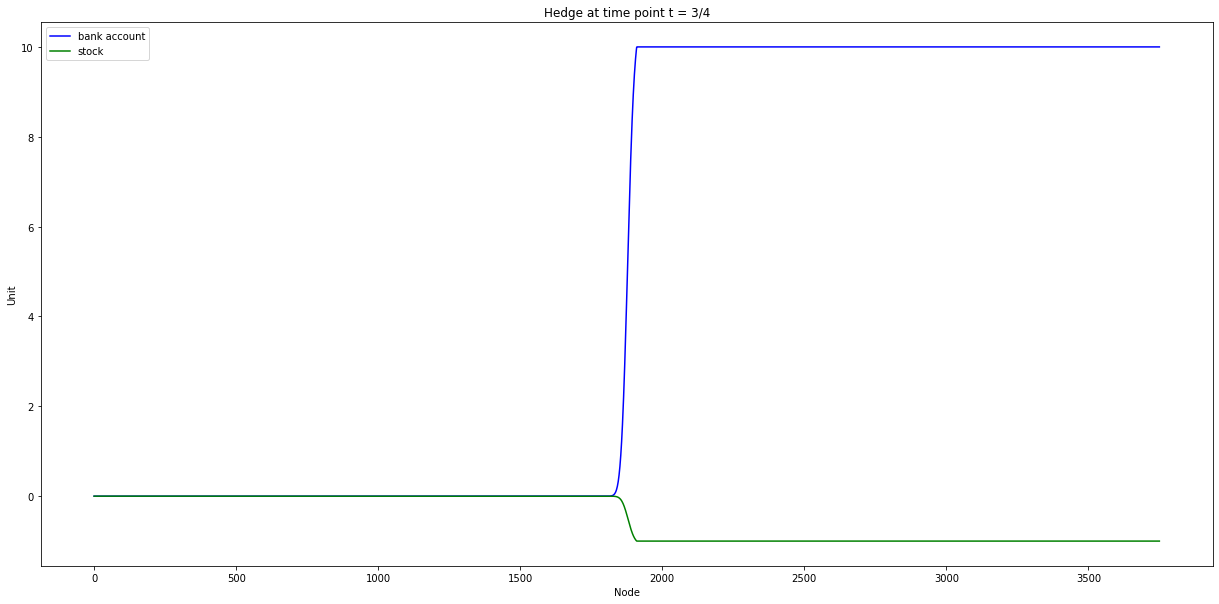

In [68]:
HedgingPlot(sigma_0_ame__002, sigma_1_ame__002, 5000)

[4.961949944442095, -0.4008866617578171]


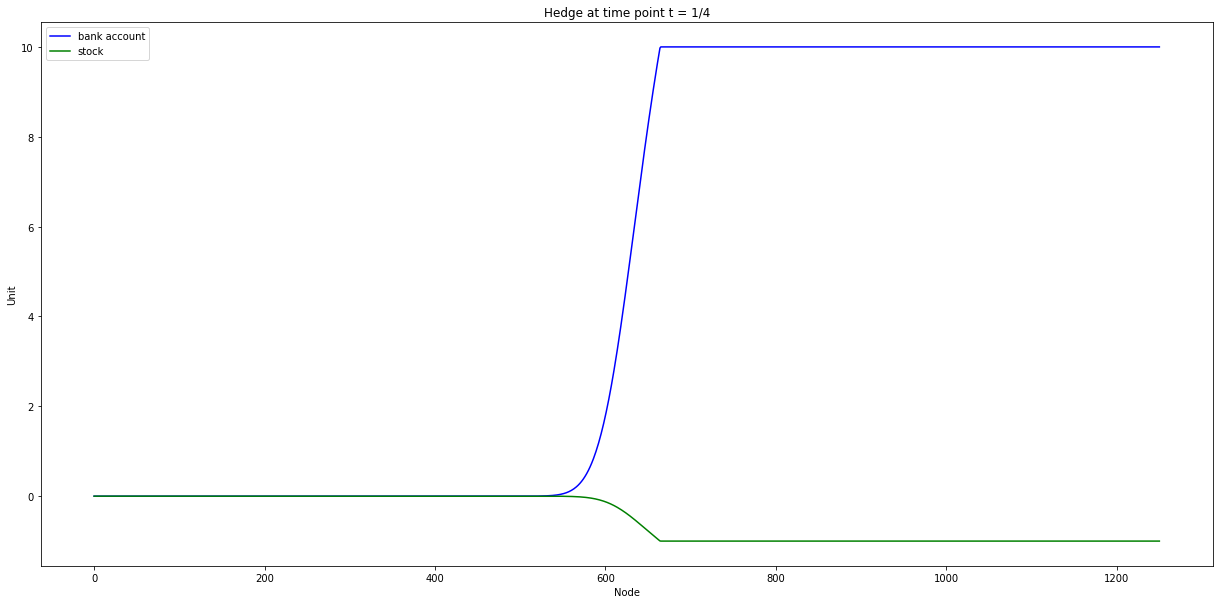

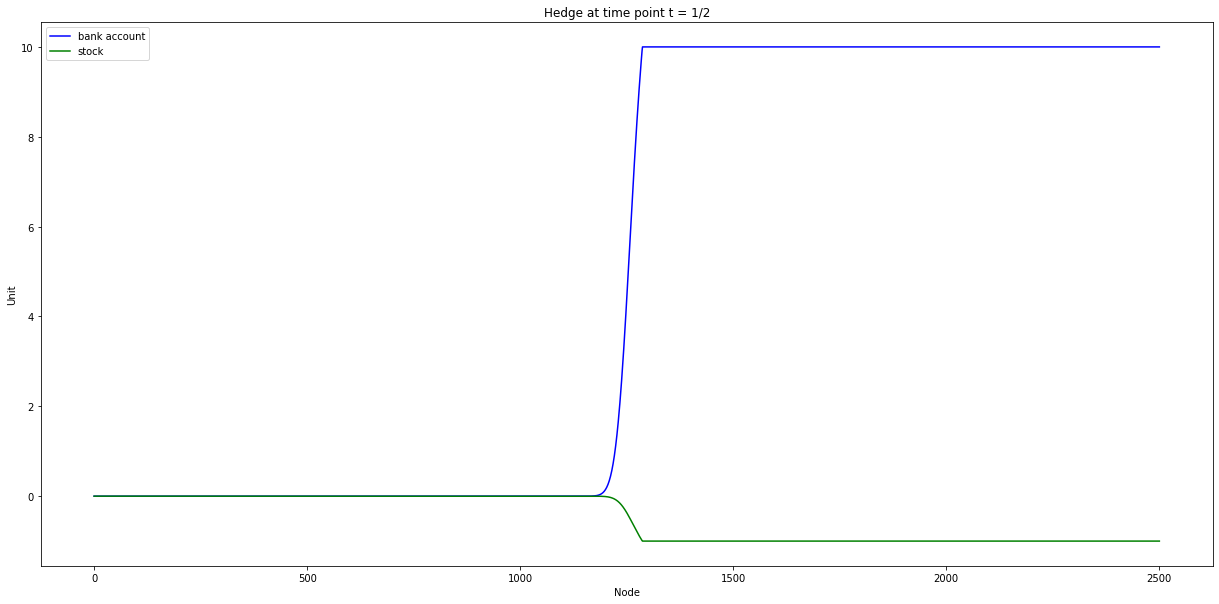

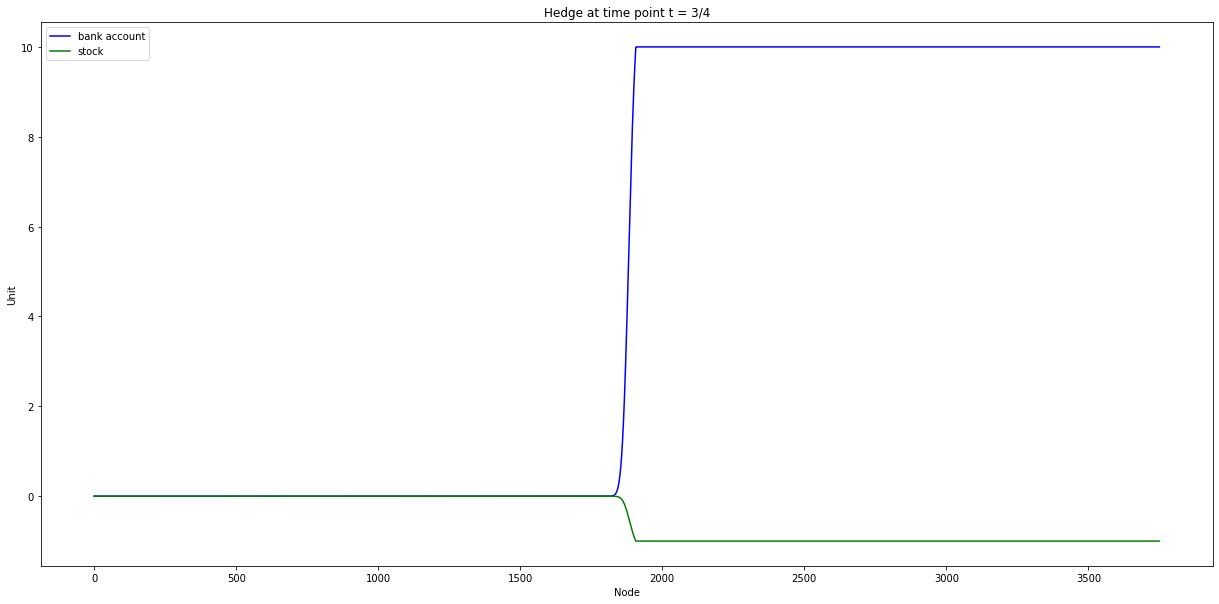

In [69]:
HedgingPlot(sigma_0_ame__006, sigma_1_ame__006, 5000)

[5.349780852976738, -0.37196331348915623]


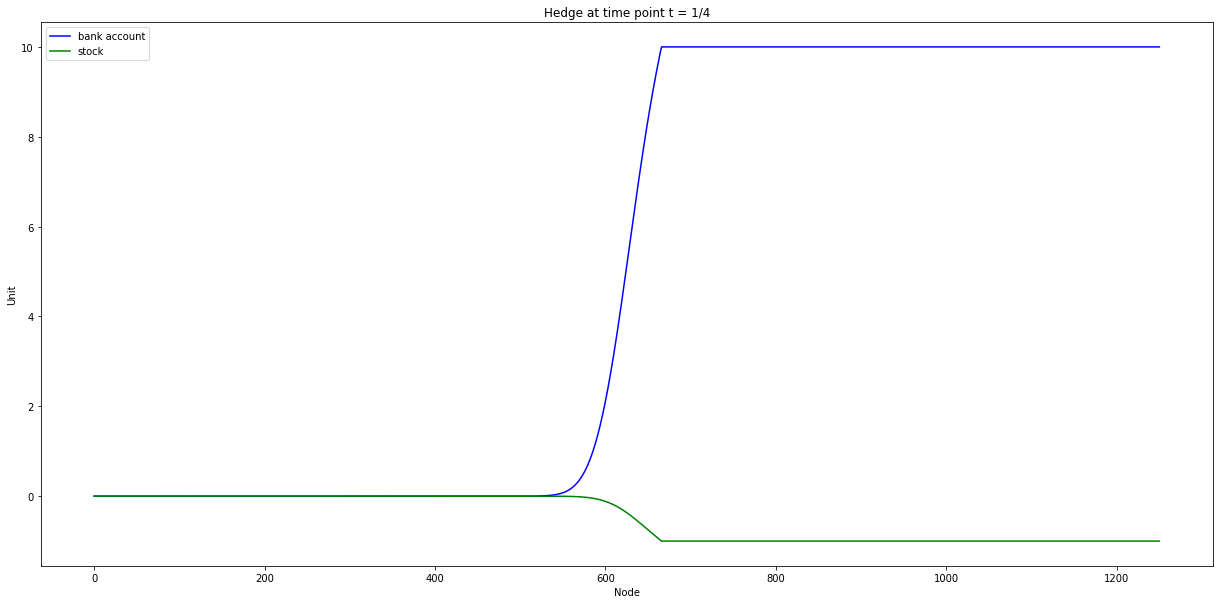

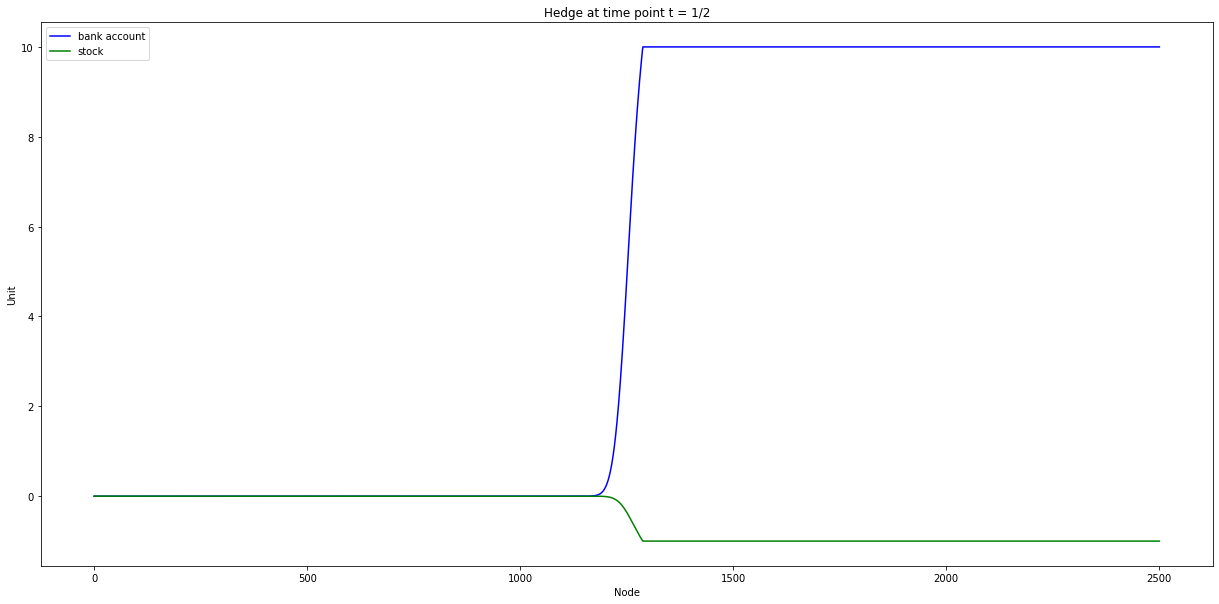

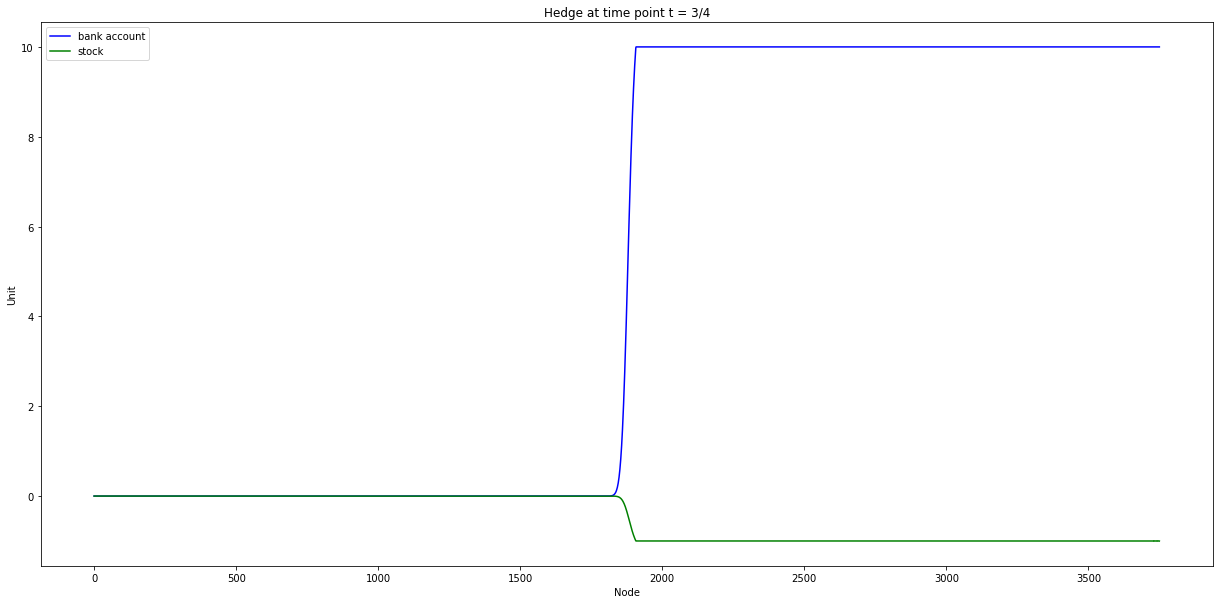

In [70]:
HedgingPlot(sigma_0_ame__008, sigma_1_ame__008, 5000)

[5.687500738195308, -0.34036991311126563]


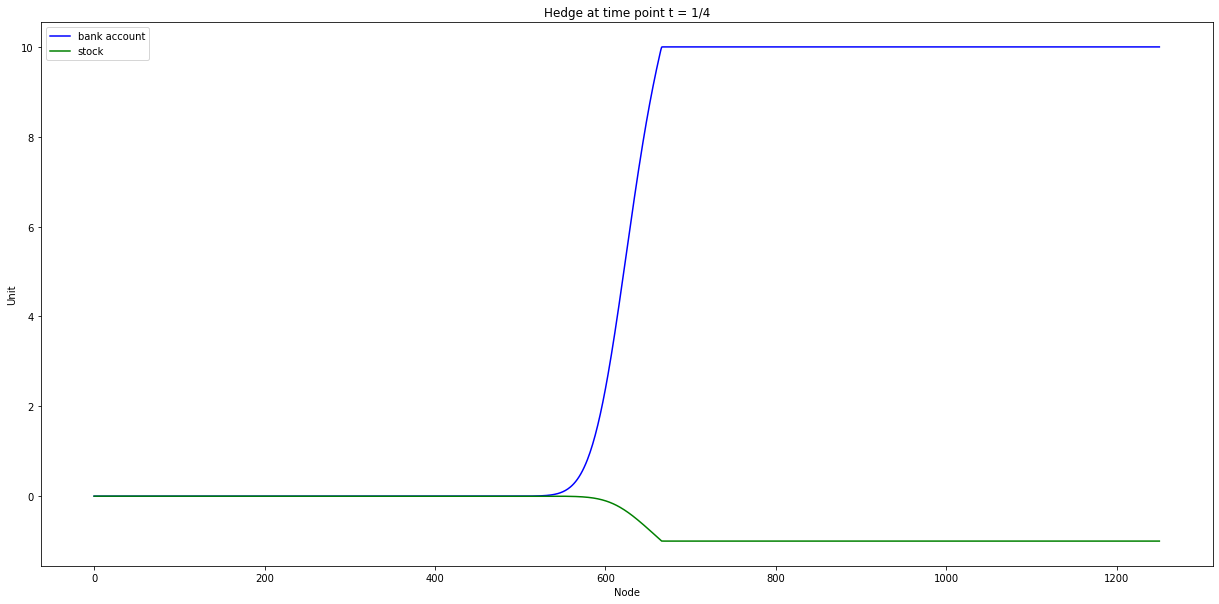

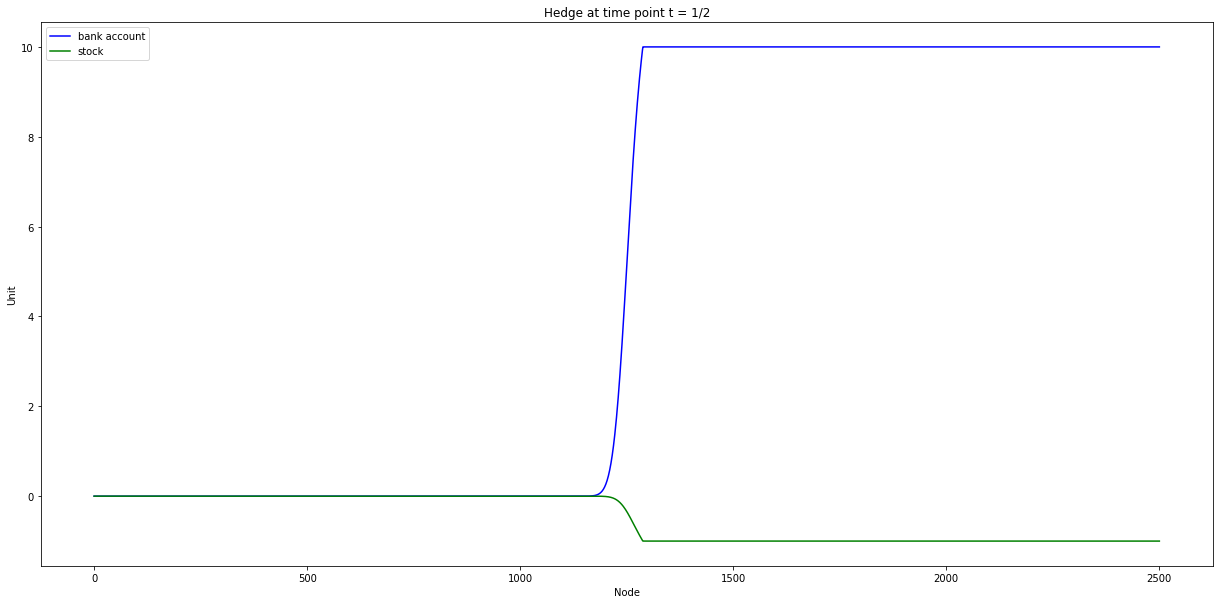

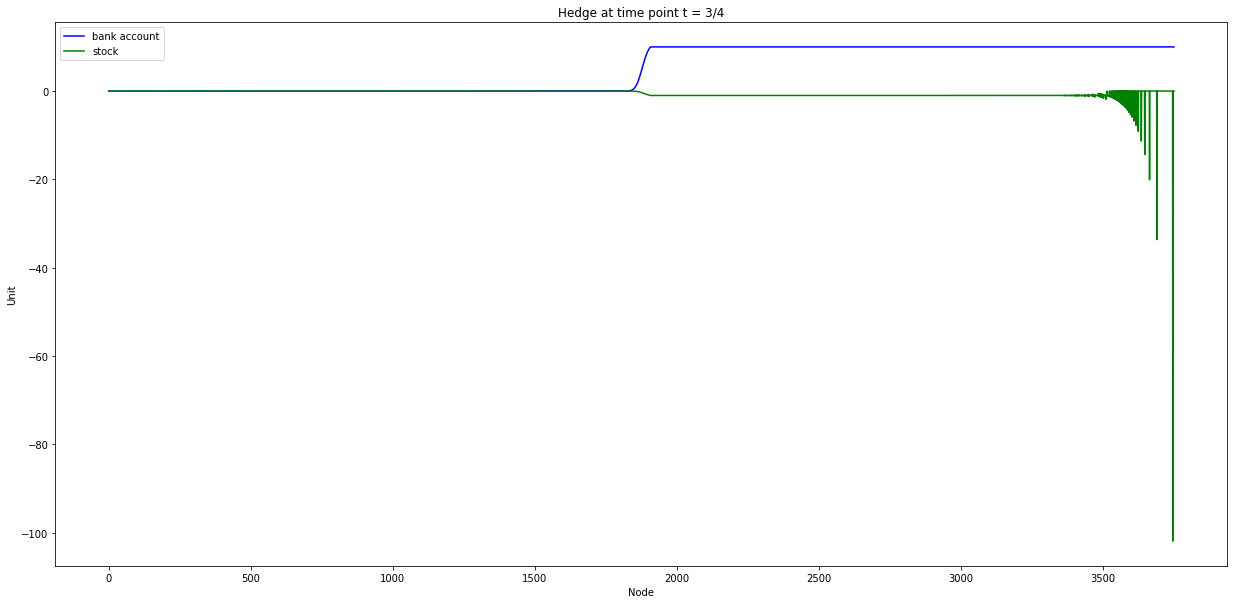

In [71]:
HedgingPlot(sigma_0_ame__010, sigma_1_ame__010, 5000)

European Plot

[5.199378089237182, -0.48006219107684145]


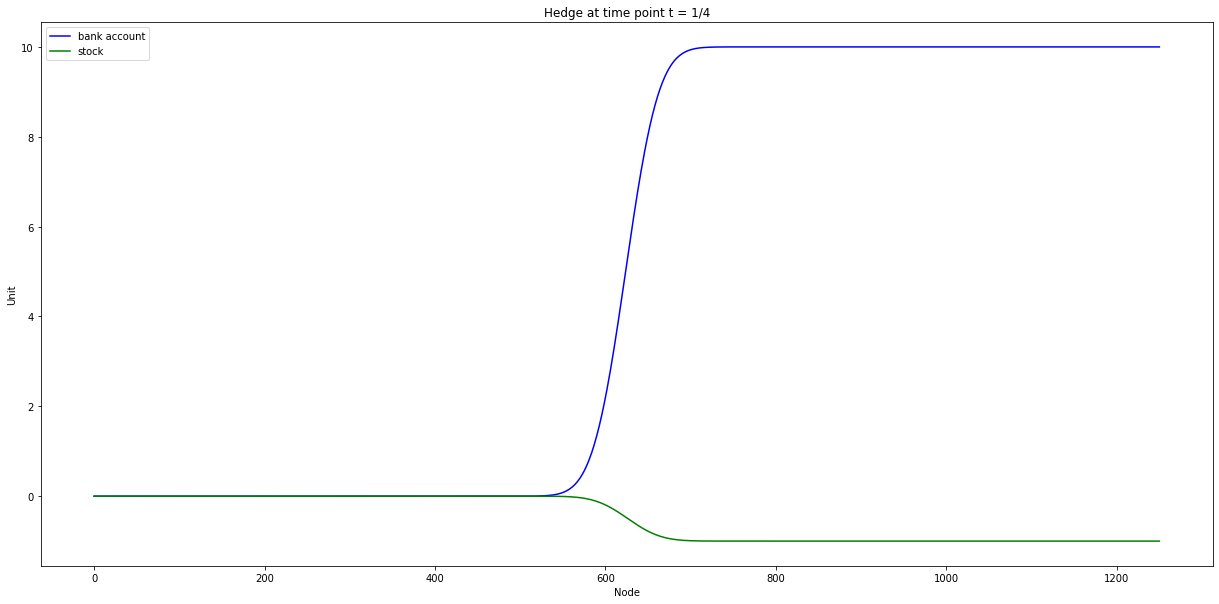

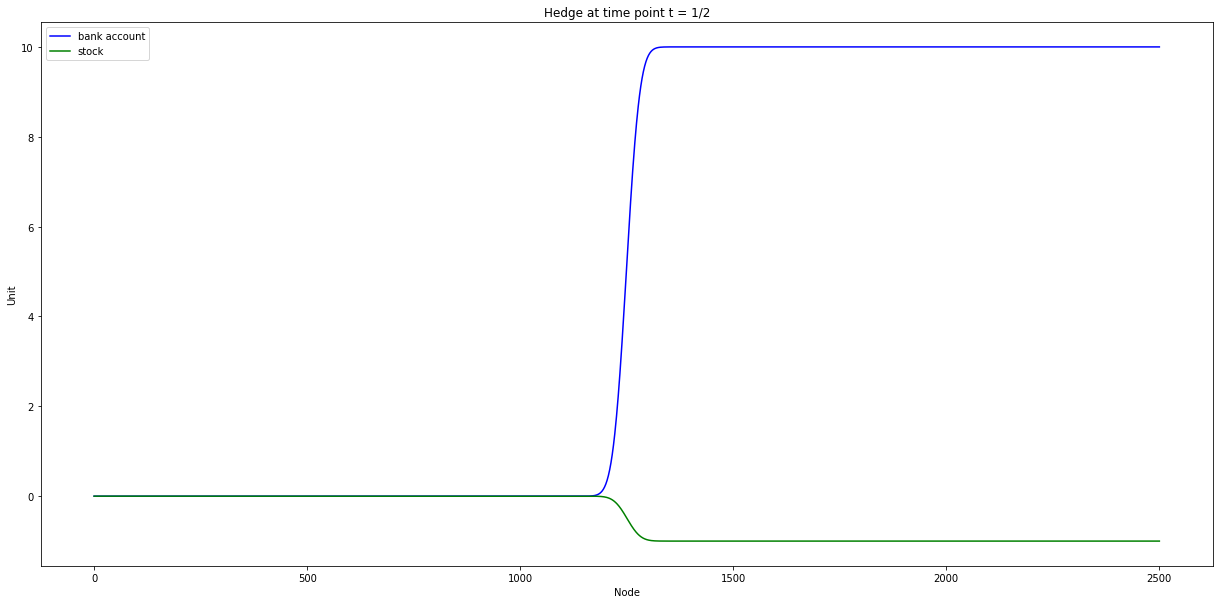

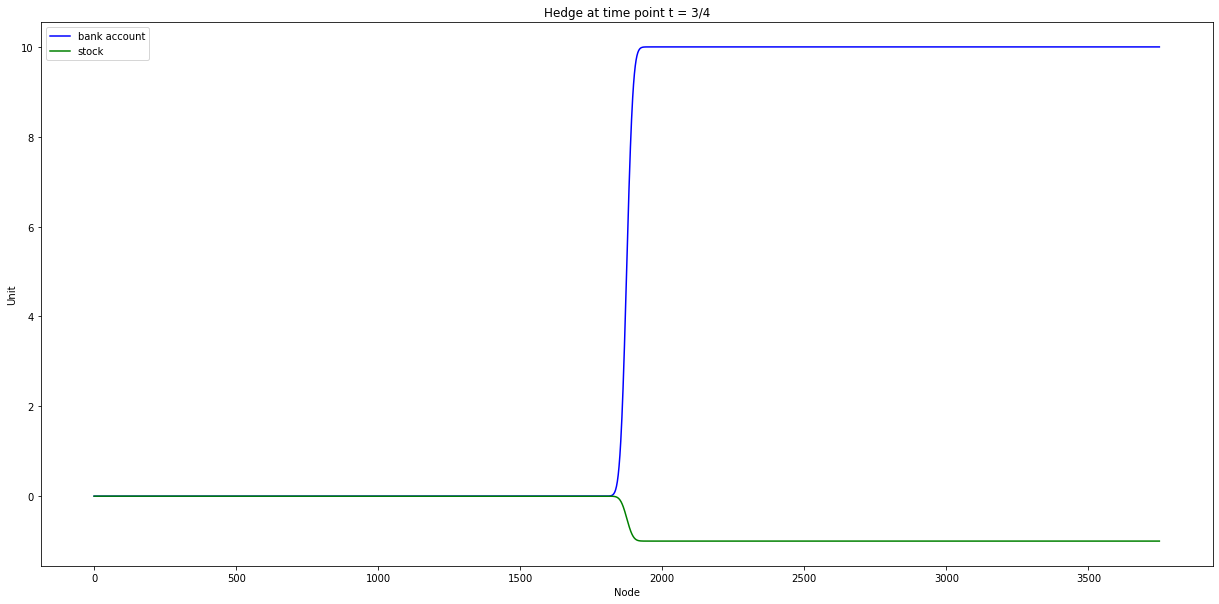

In [72]:
HedgingPlot(sigma_0_eur__0, sigma_1_eur__0, 5000)

[4.9010185271496285, -0.42073896114772186]


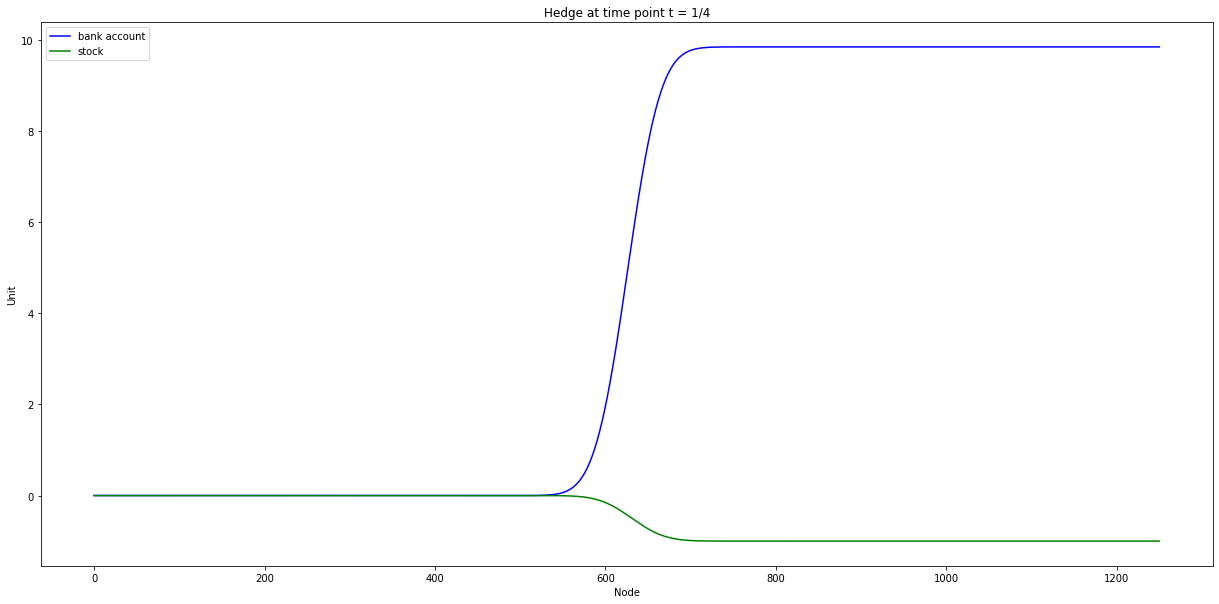

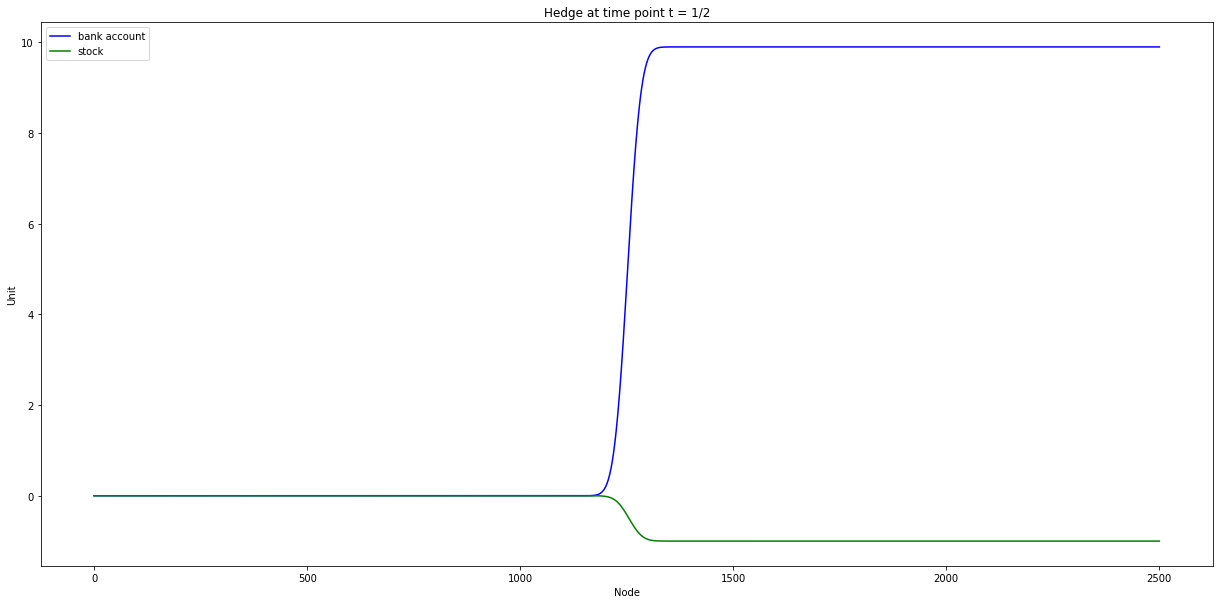

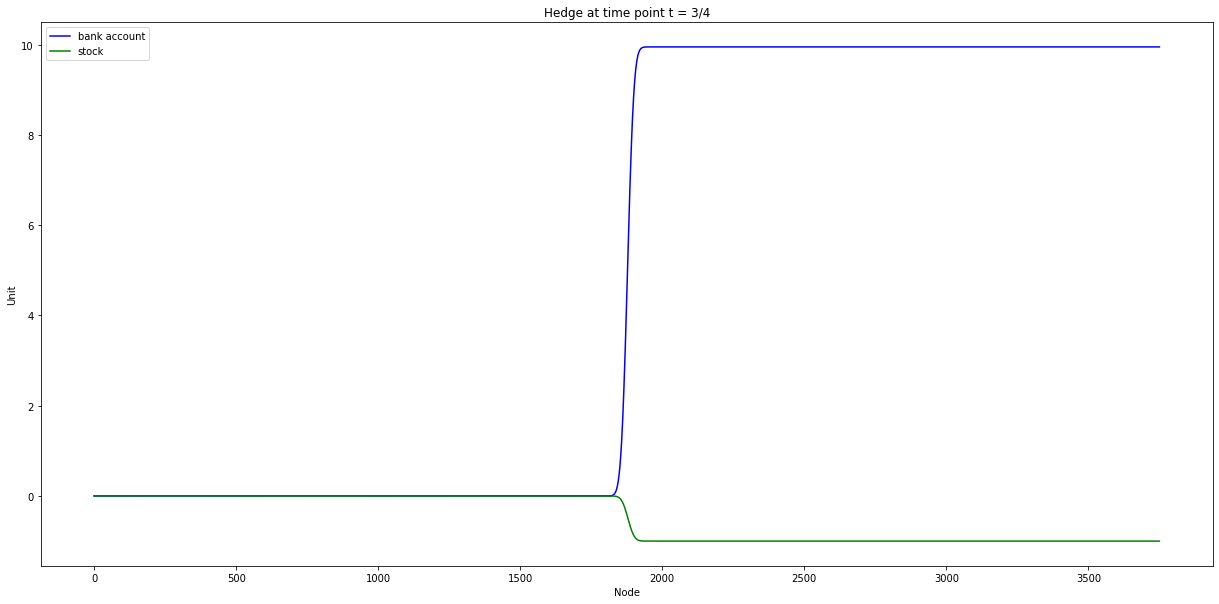

In [73]:
HedgingPlot(sigma_0_eur__002, sigma_1_eur__002, 5000)

[4.520989437497207, -0.3631664639327234]


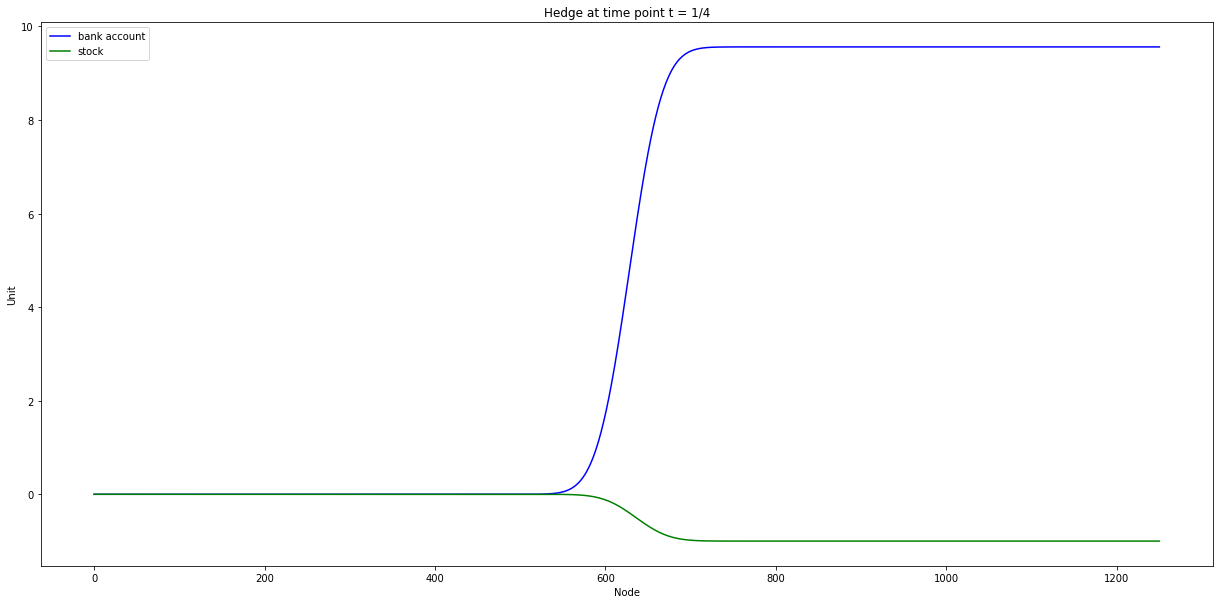

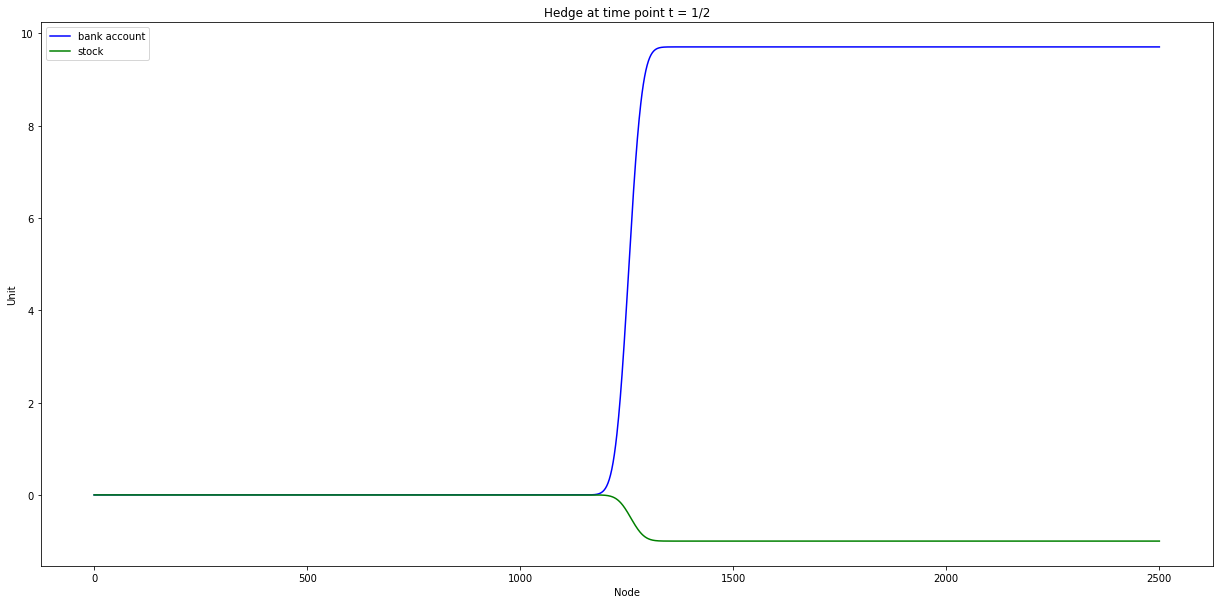

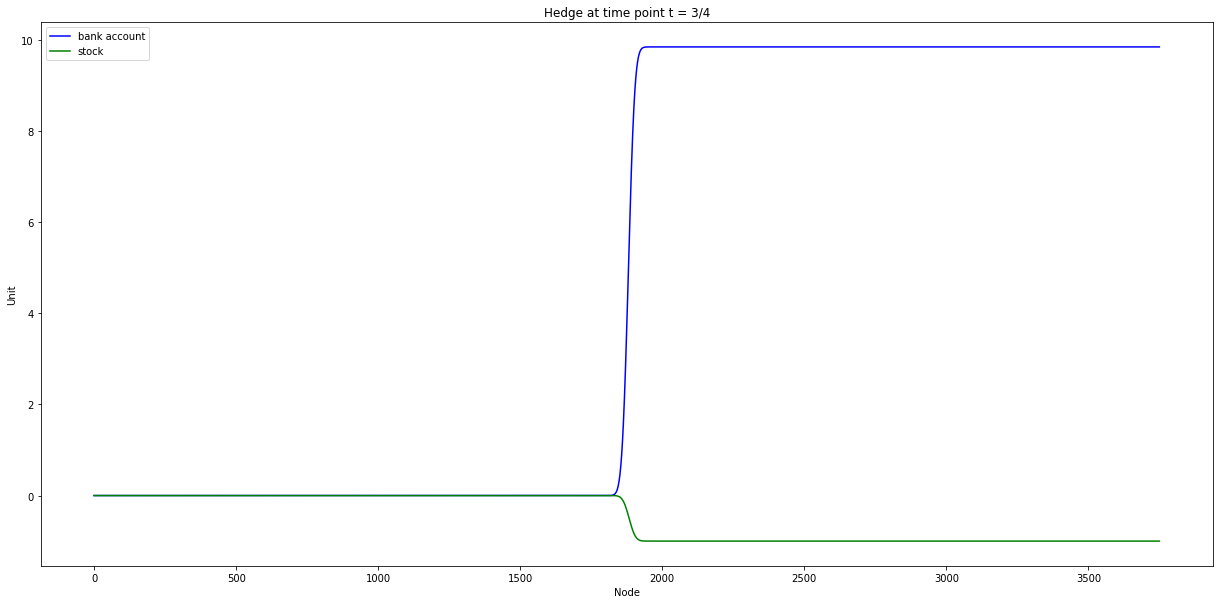

In [74]:
HedgingPlot(sigma_0_eur__006, sigma_1_eur__006, 5000)

[4.946615662414056, -0.3408996412743584]


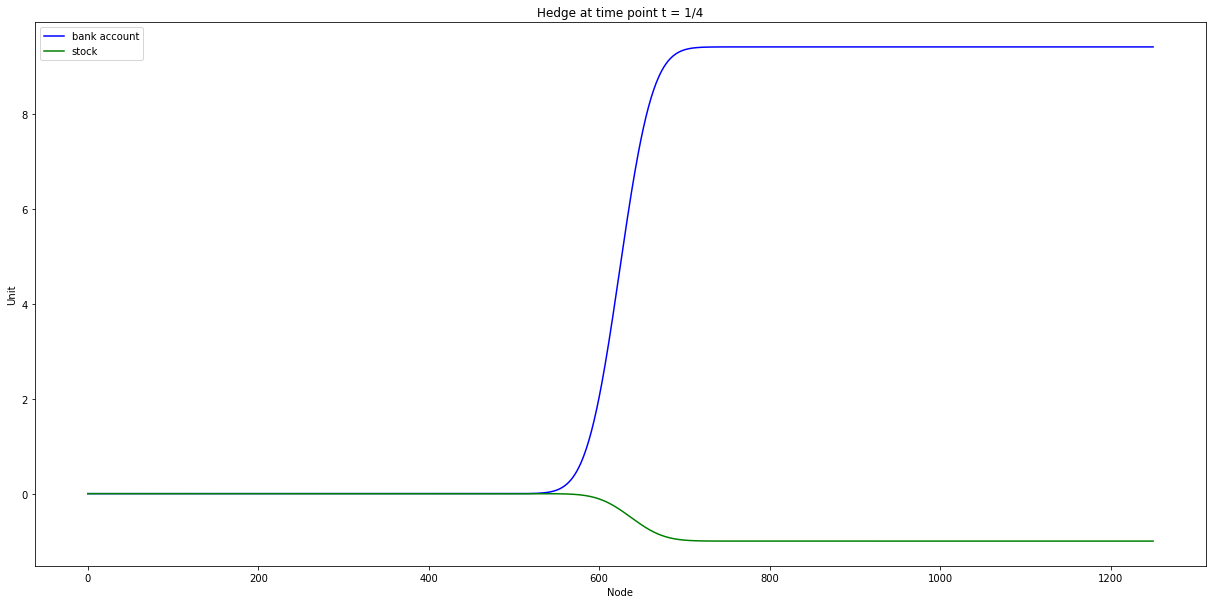

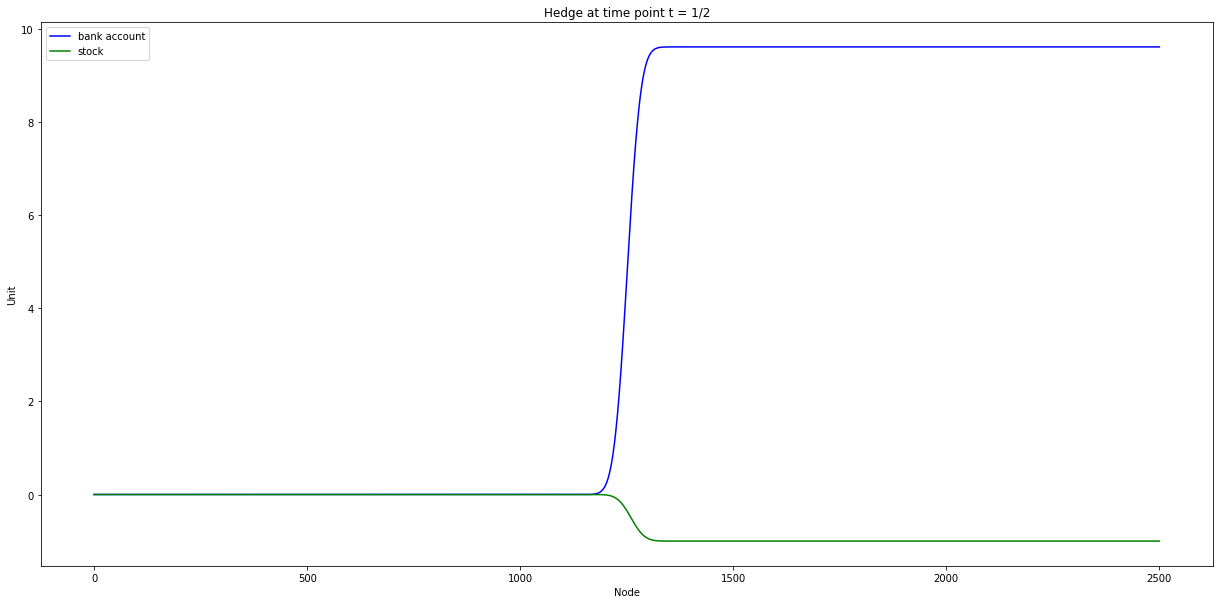

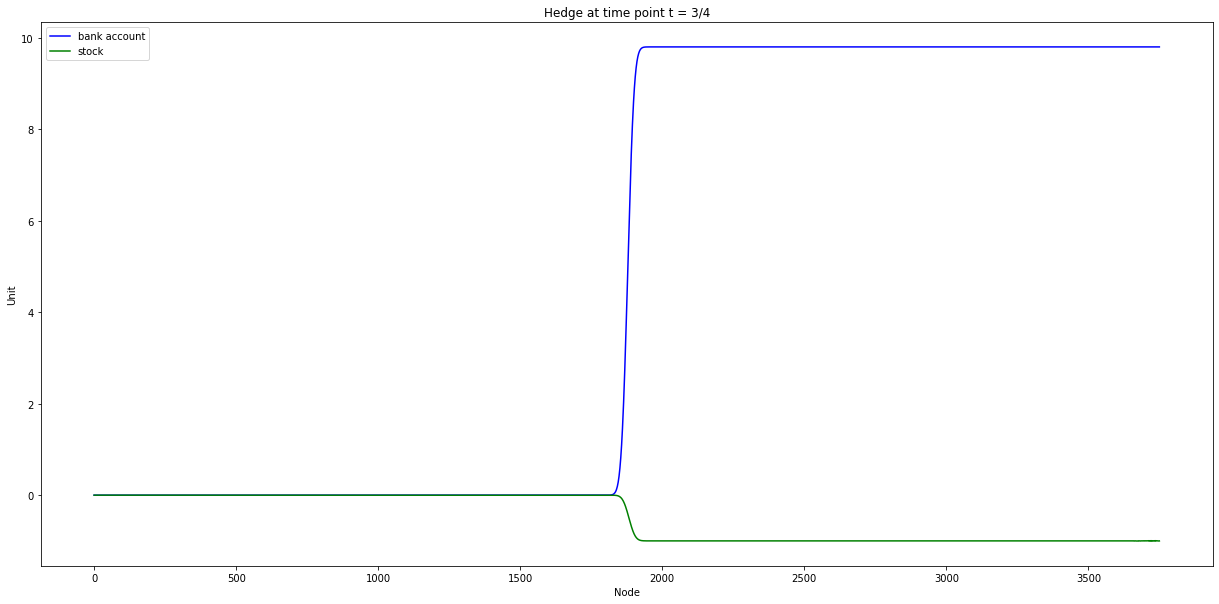

In [75]:
HedgingPlot(sigma_0_eur__008, sigma_1_eur__008, 5000)

[5.266539973676666, -0.31105756520702676]


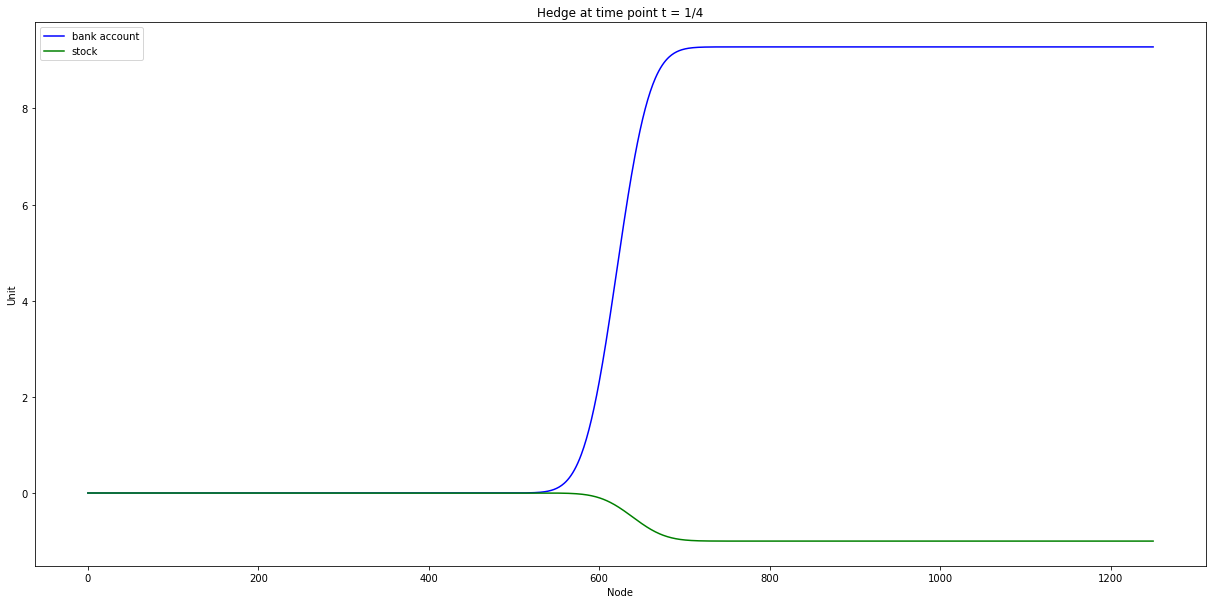

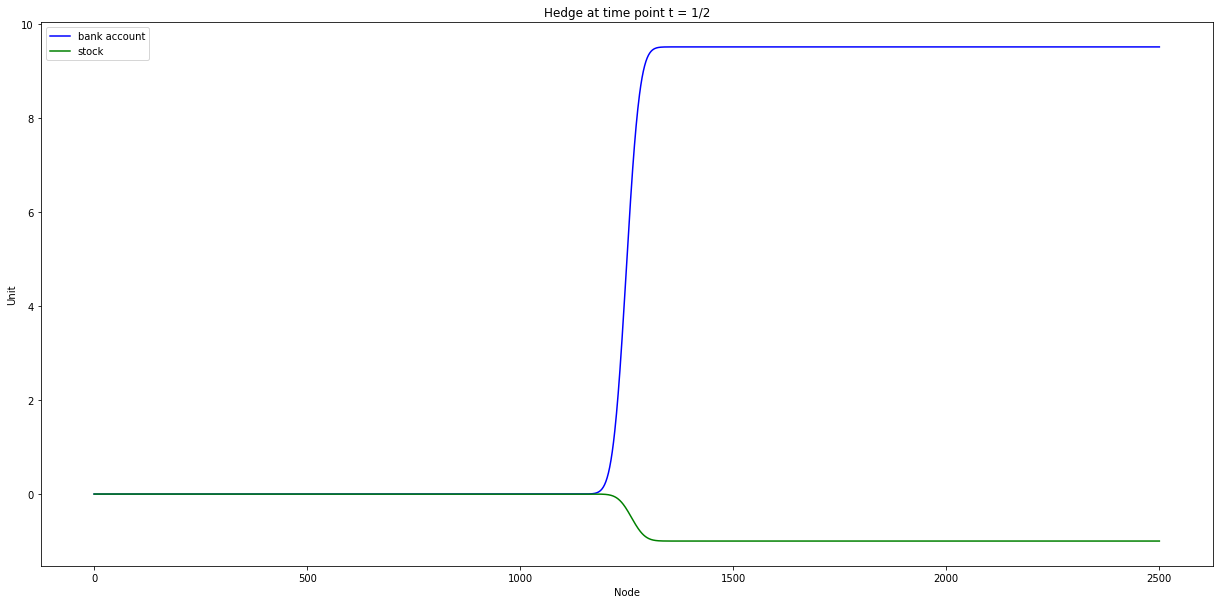

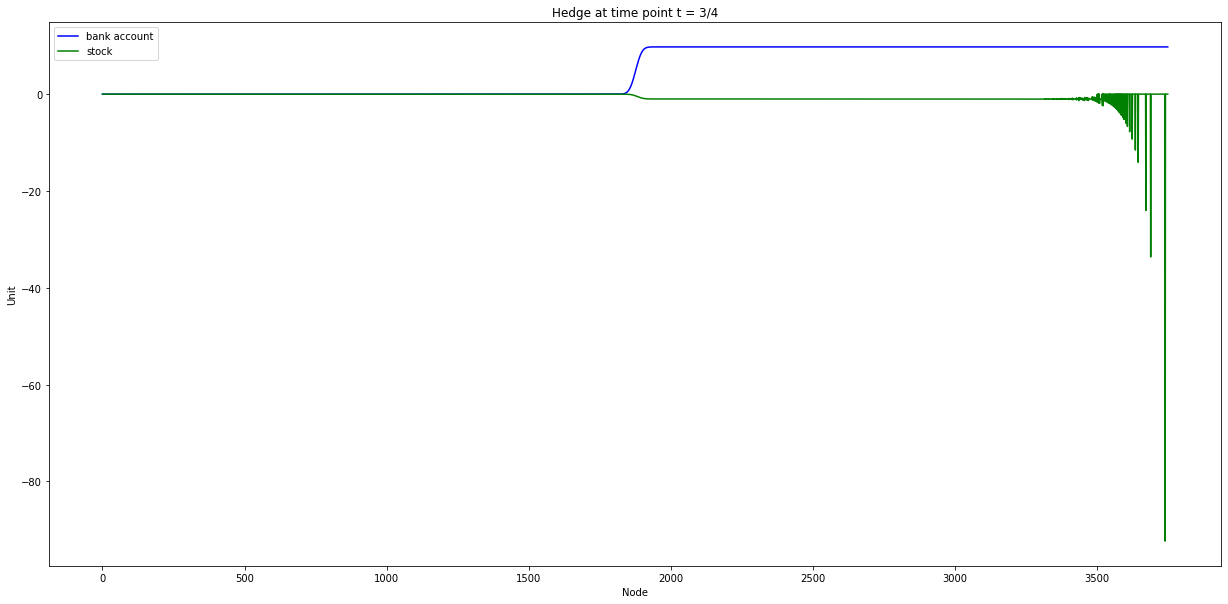

In [76]:
HedgingPlot(sigma_0_eur__010, sigma_1_eur__010, 5000)

# (b.i) Exercise Time Dist & Profit, Loss

In [4]:
def AmericanPutSim(S0, T, N, r, sigma_realized, sigma_purchase, miu, K, Npaths):
    
    np.random.seed(7)
    
    # Some value would be used
    dt = T/N
    # u = np.exp(r * dt + sigma * np.sqrt(dt))    
    p = 0.5 * (1 + ((miu - r)-0.5*(sigma_realized ** 2)) * np.sqrt(dt) / sigma_realized)
    
    asset_price = np.zeros((Npaths, N+1))
    asset_price[:,0] = S0
                 
    
    
    # Simulate the asset price
    for i in range(N):
        Indicator = np.random.rand(Npaths)
        x = 1 * (Indicator < p) - 1 * (Indicator > p )
        asset_price[:,i+1] = asset_price[:,i] * np.exp(sigma_realized * np.sqrt(dt) * x)
    # Plot the asset price
    plt.plot(asset_price.T)
    plt.xlabel('Time Step (T=1, N=5000)')
    plt.ylabel('Asset Price')
    plt.title('Asset Price Simulation 10000 paths')
    plt.show()
    


    # The price and exercise boundary for the put option
    asset_tree, option_tree, hold_tree, intrinsic_tree = AmericanPut(S0 = S0, T = T, N = N, r = r, sigma = sigma_purchase, K = K)
    exercise_boundary_set = asset_tree.copy()
    exercise_boundary_set[(K - asset_tree - option_tree) < 0] = 0 
    exercise_boundary = exercise_boundary_set.max(axis = 0)
    
    
    

    # List of exercise time
    exercise_boundary_matrix = np.reshape(exercise_boundary, (N+1,1))    
    exercise_boundary_matrix = np.repeat(exercise_boundary_matrix, Npaths, axis = 1)
    exercise_time = np.argmax(np.transpose(asset_price) <= exercise_boundary_matrix, axis = 0)
    exercise_time[exercise_time == 0] = N
    # plot
    sns.kdeplot(data = exercise_time)
    plt.xlabel('Time t')
    plt.title('KDE of Exercise Time')
    plt.show()
    
    
    
    # The profit and loss
    # Max(K-S,0) - option_tree[0][0]
    exercise_price = np.zeros((Npaths,))
    for i in range(Npaths):
        if exercise_time[i] == N:
            exercise_price[i] = asset_price[i][N]
        elif exercise_time[i] != N:
            exercise_price[i] = asset_price[i][exercise_time[i]]
    profit_loss = np.maximum(K - exercise_price, 0) - option_tree[0][0]
    # plot
    sns.kdeplot(data = profit_loss)
    plt.xlabel('Profit and Loss Money')
    plt.title('Profit and Loss')
    plt.show()

    
    return asset_price, exercise_time

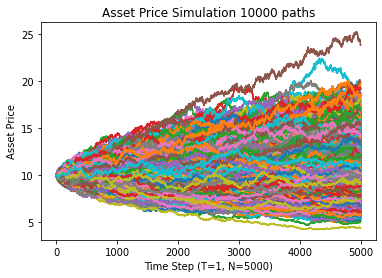

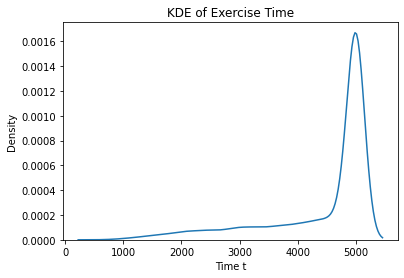

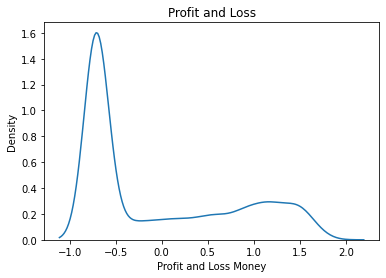

In [5]:
asset_price, exercise_time = AmericanPutSim(10, 1, 5000, 0.02, 0.2, 0.2, 0.05, 10, 10000)

# (b.ii) Realized Volatility is σ = 10%, 15%, 20%, 25%, 30%

10%

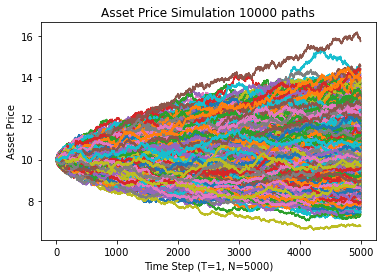

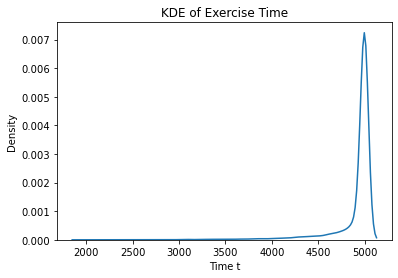

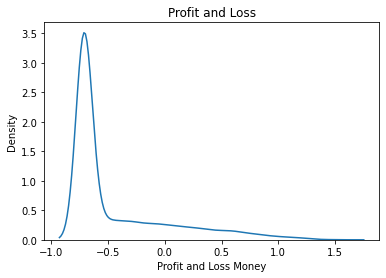

In [ ]:
asset_price, exercise_time = AmericanPutSim(10, 1, 5000, 0.02, 0.1, 0.2, 0.05, 10, 10000)

15%

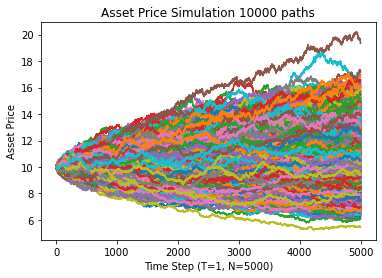

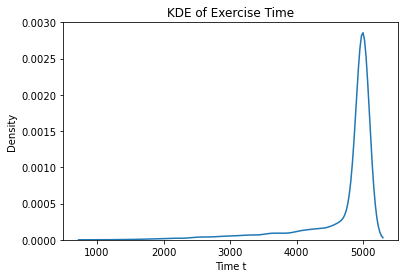

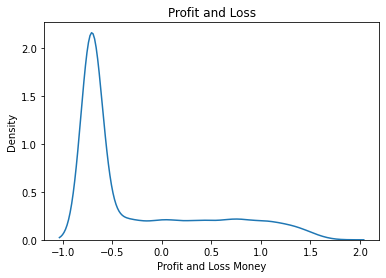

In [ ]:
asset_price, exercise_time = AmericanPutSim(10, 1, 5000, 0.02, 0.15, 0.2, 0.05, 10, 10000)

20%

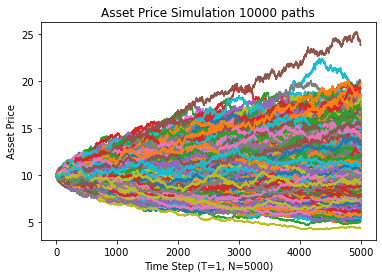

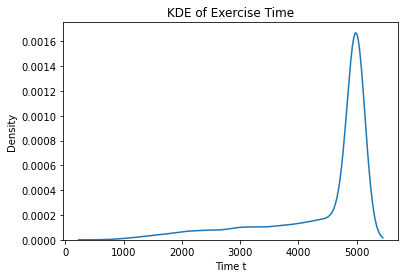

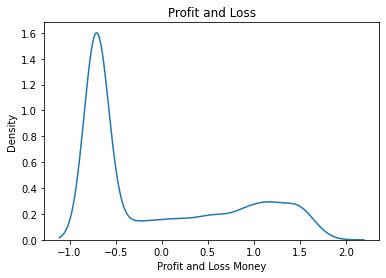

In [ ]:
asset_price, exercise_time = AmericanPutSim(10, 1, 5000, 0.02, 0.2, 0.2, 0.05, 10, 10000)

25%

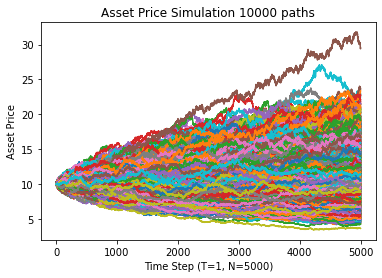

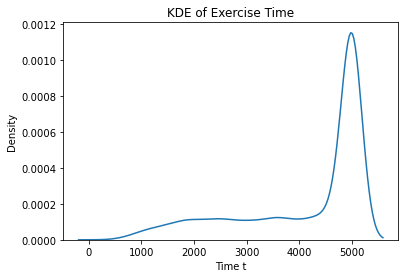

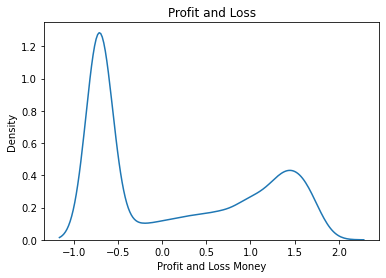

In [ ]:
asset_price, exercise_time = AmericanPutSim(10, 1, 5000, 0.02, 0.25, 0.2, 0.05, 10, 10000)

30%

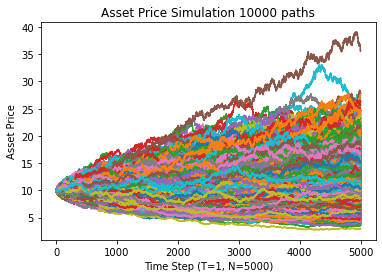

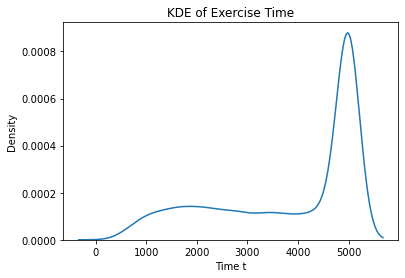

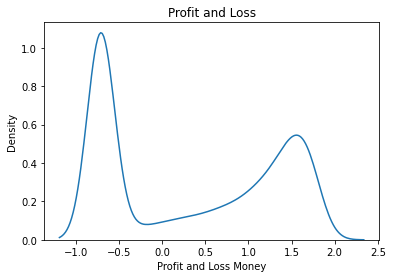

In [ ]:
asset_price, exercise_time = AmericanPutSim(10, 1, 5000, 0.02, 0.3, 0.2, 0.05, 10, 10000)